**Empirical Asset Pricing with Individual Stocks on the JSE: Betas Versus Characteristics**

# Preparation

## Load any required modules

In [1]:
%matplotlib inline
import linearmodels
import json
import random
import pandas as pd
import numpy as np
import seaborn as sn
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
from datetime import datetime
from scipy import stats
from tqdm import tqdm
from scipy.stats.mstats import spearmanr
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS
from scipy.stats.mstats import winsorize

In [4]:
random.seed(12345)

In [5]:
# plt.rcParams["figure.figsize"] = (5, 3.5) # Define the size of figures

In [6]:
random.seed(12345)
print(random.random())

0.41661987254534116


## Define Functions 

Define the "replacer" funtion to replace the consecutive 0s with np.NaN in each column

In [7]:
def replacer(l,target_val=0,replace_val=np.NaN,repeat_max=10):
    #repeat_max = n (consecutive 0s over 10 times will be replaced with NAs)
    counter = 0
    new_l = []
    for e in l:
        if e == target_val: counter += 1
        else:
            counter = 0

        if counter > repeat_max:
            new_l.append(replace_val)
        else:
            new_l.append(e)

    return new_l

Define Newey-West t-test For Time-Series Data

In [8]:
def NW_ttest(ret,h0):
  T = len(ret)
  lag = int(4*(T/100)**(2/9))
  vv = np.var(ret)

  for l in range(0,lag):
      cc=np.cov(ret[0:(len(ret)-l)].T,ret[l:len(ret)].T)[0,1]
      vv=vv+2*(1-(l+1)/lag)*cc
      t=(np.mean(ret)-h0)/np.sqrt(vv)*np.sqrt(T)
  
  return t

Define the unlist function

In [9]:
def flatten(t):
    return [item for sublist in t for item in sublist]

GRS test for joint Alpha Distribution

In [11]:
"""
Function GRS_test(factor, resid, alpha) is to conduct GRS test according 
to Gibbons, Ross & Shanken(1989) to receive GRS-statistic and p-value.

H0: alpha1=alpha2=...=alphaN=0

Parameters:
  T = number of months
  N = number of portfolios/stocks
  L = number of factors

Inputs:
  factor: matrix of FF factors with shape (T, L)
  resid: matrix of residuals with shape (T, N)
  alpha: matrix of intercepts with shape (N, 1)

Outputs:
  f_grs: GRS-statistic
  p_grs: P-value

"""
from scipy.stats import f

def GRS_test(factor, resid, alpha):
    N = resid.shape[1]        
    T = resid.shape[0]       
    L = factor.shape[1]      

    if (T-N-L) < 0:
        print('can not conduct GRS test because T-N-L<0')
        return

    factor = np.asmatrix(factor)                   # factor matrix (T, L)
    resid = np.asmatrix(resid)                     # residual matrix (T, N)
    alpha = np.asmatrix(alpha).reshape(N, 1)       # intercept matrix (N, 1)

    mean_return_factor = (factor.mean(axis=0))

    # covariance matrix of residuals
    cov_resid = (resid.T * resid) / (T-L-1)
    # covariance matrix of factors
    cov_factor = ((factor - mean_return_factor).T * (factor - mean_return_factor)) / (T-1)

    mean_return_factor = mean_return_factor.reshape(L, 1)

    # GRS statistic
    # pinv.linalg.pinv is a pseudoinverse not a real one, for calculating the real inverse we need to use np.linalg.inv
    # However, the structure of resids matrix is oftenly a Singular matrix (one for which a inverse matrix does not exis)
    f_grs = float((T/N) * ((T-N-L)/(T-L-1)) * ((alpha.T * np.linalg.pinv(cov_resid) * alpha) / (1 + mean_return_factor.T * np.linalg.inv(cov_factor) * mean_return_factor)))

    # p-value
    p_grs = 1 - stats.f.cdf(f_grs, N, (T-N-L))

    return f_grs, p_grs


In [10]:
ols_model = LinearRegression()

## Import Data

In [12]:
# Import excessive market return (J203T - Rf)
df_MR = pd.read_csv('df_MR.csv')
df_MR.Dates = df_MR.Dates.apply(lambda x:x[:10])
df_MR.set_index('Dates',inplace=True)

Import risk-free rate (91-day T-Bill)

In [13]:
df_RF = pd.read_csv('df_RF.csv',index_col=0)

Import listed stock returns on the JSE

In [18]:
df_SR = pd.read_csv('df_SR.csv',index_col=0)
df_SR.index = df_SR.index.to_series().apply(lambda x:x[:10])

Drop the columns of stock returns that full of 0s or NAs and replace consecutive 0s with NAs

In [19]:
df_SR = df_SR.loc[:, (df_SR != 0).any(axis=0)].astype(np.float64)
df_SR = df_SR.dropna(axis = 0, how = 'all')
df_SR = df_SR.apply(replacer)

Calculate the Excess Stock Returns 

In [146]:
df_Ex_SR = df_SR-df_RF.values

In [147]:
df_Ex_SR

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.020678,-0.015547,0.012542,-0.038019,-0.020355,0.003464,-0.024971,-0.046701,-0.041012,-0.009411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,-0.015876,-0.039501,0.075345,-0.000279,-0.000279,0.010867,-0.078240,-0.006779,-0.048165,0.014896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.004951,0.017172,0.079162,0.037465,-0.000275,0.021650,0.013148,0.052647,0.034541,0.041029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,0.040553,0.053297,0.066534,-0.000275,0.026405,-0.037089,0.088956,0.116362,0.075726,0.020698,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-11,0.078535,0.029097,0.019928,0.014431,0.012802,0.005955,0.070342,0.044575,-0.050305,-0.044641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,NaN,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,-0.000190,...,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190
2019-12-26,NaN,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,-0.000190,...,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190
2019-12-27,NaN,NaN,-0.000308,NaN,-0.000189,NaN,0.004422,NaN,0.003483,0.012353,...,-0.062710,0.007442,-0.003571,-0.009381,0.002857,0.018901,0.015940,-0.003086,0.023825,0.010409


Import the Factor Realizations (Mimicking portfolio returns)

In [22]:
df_FF3 = pd.read_csv('df_FF3.csv')
df_FF3.Dates = df_FF3.Dates.apply(lambda x: x[:10])
df_FF3.set_index('Dates',inplace=True)

In [23]:
df_FF4 = pd.read_csv('df_FF4.csv')
df_FF4.Dates = df_FF4.Dates.apply(lambda x:x[:10])
df_FF4.set_index('Dates',inplace=True)

In [24]:
df_FF5 = pd.read_csv('df_FF5.csv')
df_FF5.Dates = df_FF5.Dates.apply(lambda x:x[:10])
df_FF5.set_index('Dates',inplace=True)

Import Firm Characteristics 

In [25]:
df_ln_Size = pd.read_csv('df_ln_Size.csv')
df_ln_Size.Dates = df_ln_Size.Dates.apply(lambda x:x[:10])
df_ln_Size.set_index('Dates',inplace=True)

In [26]:
df_PE = pd.read_csv('df_std_PE.csv')
df_PE.Dates = df_PE.Dates.apply(lambda x:x[:10])
df_PE.set_index('Dates',inplace=True)

In [27]:
df_OP = pd.read_csv('df_std_OP.csv')
df_OP.Dates = df_OP.Dates.apply(lambda x:x[:10])
df_OP.set_index('Dates',inplace=True)

In [28]:
df_INV = pd.read_csv('df_std_INV.csv')
df_INV.Dates = df_INV.Dates.apply(lambda x:x[:10])
df_INV.set_index('Dates',inplace=True)

Import 18 double-sorted portfolios returns

In [29]:
df_18_PR = pd.read_csv('df_18_PR.csv')
df_18_PR.Dates = df_18_PR.Dates.apply(lambda x:x[:10])
df_18_PR.set_index('Dates',inplace=True)

Import Firm Characteristics of 18 double-sorted portfolios

In [30]:
df_18_std_Size = pd.read_csv('df_18_std_size.csv')
df_18_std_Size.Dates = df_18_std_Size.Dates.apply(lambda x:x[:10])
df_18_std_Size.set_index('Dates',inplace=True)

In [31]:
df_18_std_PE = pd.read_csv('df_18_std_PE.csv')
df_18_std_PE.Dates = df_18_std_PE.Dates.apply(lambda x:x[:10])
df_18_std_PE.set_index('Dates',inplace=True)

In [32]:
df_18_std_OP = pd.read_csv('df_18_std_OP.csv')
df_18_std_OP.Dates = df_18_std_OP.Dates.apply(lambda x:x[:10])
df_18_std_OP.set_index('Dates',inplace=True)

In [33]:
df_18_std_INV = pd.read_csv('df_18_std_INV.csv')
df_18_std_INV.Dates = df_18_std_INV.Dates.apply(lambda x:x[:10])
df_18_std_INV.set_index('Dates',inplace=True)

In [149]:
df_Ex_SR = df_Ex_SR.apply(lambda x: winsorize(x, (0.01, 0.01)))

## Winsorize

In [285]:
df_FF3 = df_FF3.apply(lambda x: winsorize(x, (0.01, 0.01)))
df_FF4 = df_FF4.apply(lambda x: winsorize(x, (0.01, 0.01)))
df_FF5 = df_FF5.apply(lambda x: winsorize(x, (0.01, 0.01)))
df_MR = df_MR.apply(lambda x: winsorize(x, (0.01, 0.01)))

In [286]:
df_Ex_SR

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.020678,-0.015547,0.012542,-0.038019,-0.020355,0.003464,-0.024971,-0.046701,-0.041012,-0.009411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,-0.015876,-0.039501,0.066746,-0.000279,-0.000279,0.010867,-0.047144,-0.006779,-0.048165,0.014896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.004951,0.017172,0.066746,0.037465,-0.000275,0.021650,0.013148,0.052647,0.034541,0.041029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,0.040553,0.053297,0.066534,-0.000275,0.026405,-0.037089,0.051113,0.116362,0.050048,0.020698,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-11,0.078535,0.029097,0.019928,0.014431,0.012802,0.005955,0.051113,0.044575,-0.049104,-0.044641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,NaN,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,-0.000190,...,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190
2019-12-26,NaN,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,-0.000190,...,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190
2019-12-27,NaN,NaN,-0.000308,NaN,-0.000189,NaN,0.004422,NaN,0.003483,0.012353,...,-0.060519,0.007442,-0.003571,-0.009381,0.002857,0.018901,0.015940,-0.003086,0.023825,0.010409


# Empirical Results

This section employs the OLS and IV methods to estimate the premiums for risk factors proposed by prominent asset pricing models.

## FM-OLS Regression (Time-Varying Betas)

This Section first tests whether the risk premiums under the CAPM and the FF3- and FF5-Factor Models are significantly different from zero using the OLS method with individual stocks. For the OLS tests, the regression is fitted with daily return data from month t-36 to month t-1 to estimate beta for month t. 

### CAPM Model

How many years in the rolling estimation window?

In [151]:
n = 3

Define the length of rolling window and rebalance frequency

In [152]:
holding = 21
rollingW = holding * n *12
lens = len(df_MR)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

211 756


This cell is the first stage of FM-OLS regression, which is used to estimate market betas by regressing stock returns on market factor returns

In [153]:
# Keep the stock returns has the same length as market returns
df_Ex_SR_trnct = df_Ex_SR.loc[df_MR.index,:]

all_betas = []

for i in tqdm(range(periods)):

    df_MR_tmp = df_MR.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []
    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) != 0:
            b = list(ols_model.fit(df_MR_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'stock'}).set_index('stock')
    
    all_betas.append(df_betas)

100%|██████████| 211/211 [00:31<00:00,  6.61it/s]


In [154]:
# Print market betas for one period
all_betas[0].head()

,MKT
stock,
FDS.SJ.Equity,0.7329256988252977
MOZ.SJ.Equity,0.6017633412674951
MTN.SJ.Equity,1.190955333430266
TRT.SJ.Equity,0.4457159275049717
AEG.SJ.Equity,0.47038267934169764


This cell is the second stage of FM-OLS regression, which aims to estimate market risk premiums

In [155]:
all_lambdas = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    # k is stock on cross-section
    i = int(index_times.index(k) / holding)
    # i is time in periods
    df_return = df_Ex_SR_tmp_T.loc[all_betas[i].index,k].dropna()
    df_index = df_return.index
    
    if len(df_index) != 0:
        ols = sm.OLS(df_return, sm.add_constant(all_betas[i].loc[df_index,:].astype(np.float64)))
        res = ols.fit()
        l = list(res.params)
        
        lambdas.append(l)
        
all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 4431/4431 [00:07<00:00, 622.37it/s]


In [156]:
# Print market risk premiums and intercepts
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,0.001939,0.008583
1,0.014989,-0.017459
2,0.002477,0.006854
3,0.000111,0.006181
4,0.002605,0.004420
...,...,...
4426,0.002668,-0.002501
4427,-0.003448,0.009555
4428,0.000233,0.011673
4429,0.013536,-0.009796


In [157]:
# Print the time-series mean of market risk premiums and intercepts
print(np.mean(all_lambdas[0], axis = 0)*21*100)

0    1.580731
1   -1.513160
dtype: float64


In [158]:
stats.ttest_1samp(all_lambdas[0], 0)

Ttest_1sampResult(statistic=array([ 8.58207584, -3.40392275]), pvalue=array([1.27162290e-17, 6.70151108e-04]))

In [159]:
# Use the Newey-West t-test to examine market risk premiums and intercepts
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis = 0)

0    4.885877
1   -2.104872
dtype: float64

### —Adding Control Variables

The significance of factor risk premium estimates may due to an omitted variable bias because the second-stage cross-sectional regressions do not control for corresponding firm charactersitics. For mitigating this potential bias, we add characteristics as control variables in the second stage. 

In [160]:
# Keep the size and PE have the same length as stock returns
df_ln_Size_trnct = df_ln_Size.loc[df_Ex_SR_trnct.index,:]
df_PE_trnct = df_PE.loc[df_Ex_SR_trnct.index,:]

In [161]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)

True

In [162]:
# Stock returns are forward for 21 days compared to firm characteristics 
Gap = 21

In [163]:
# This cell represents the second stage of FM-OLS regression, which estimates the market risk premiums 
# by controlling for Size and PE characteristics.
all_lambdas = []
all_intercepts = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)


for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):
    # k is date t in len(df_Ex_SR_tmp) days
    i = int(index_times.index(k) / holding)
    # i is time T in 185 periods
    # df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan), the -inf in ln_Size data dataframe would interrupt the regression
    df_index = (((all_betas[i].index).intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index).\
                   intersection(df_PE_tmp_T.loc[:,k].dropna().index)).\
                    intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index))
    
    if len(df_index) != 0:
        
        l = list(ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], \
                                           df_ln_Size_tmp_T.loc[df_index,k],\
                                           df_PE_tmp_T .loc[df_index,k]],axis = 1).values), \
                               (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).coef_)
        
        h = ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], \
                                      df_ln_Size_tmp_T.loc[df_index,k],\
                                      df_PE_tmp_T .loc[df_index,k]],axis = 1).values), \
                          (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).intercept_
        
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 4410/4410 [00:16<00:00, 262.04it/s]


In [164]:
# Print regression intercepts 
all_intercepts[0]

,0
0,0.003553
1,0.005310
2,0.005023
3,0.001506
4,0.010663
...,...
4405,0.004295
4406,-0.005358
4407,-0.001963
4408,0.009288


In [165]:
# Print market risk premiums and the slope coefficients of characteristics
all_lambdas[0].rename(columns={0:'MKT',1:'Size',2:'PE'})

,MKT,Size,PE
0,-0.008932,-0.000226,0.001625
1,-0.014920,0.006196,-0.002010
2,-0.000038,-0.007376,-0.003655
3,-0.002685,-0.000040,-0.000388
4,-0.013595,-0.004658,-0.001860
...,...,...,...
4405,-0.010202,0.003646,-0.004467
4406,0.016518,-0.003647,-0.000604
4407,0.020022,-0.003323,0.002260
4408,0.007709,-0.008711,-0.001006


In [166]:
# Print the mean of intercepts
np.mean(all_intercepts[0], axis = 0)*21*100

0    0.970091
dtype: float64

In [172]:
# Print the mean of market risk premiums
np.mean(all_lambdas[0], axis=0)*21*100

0    0.277997
1   -0.973660
2   -0.125178
dtype: float64

In [168]:
# Print the result of ordinary t-test
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([5.21049603])

In [169]:
# Print the result of ordinary t-test
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([ 0.48876303, -4.64453912, -1.31515484])

In [170]:
## Newey-West t-test
all_intercepts[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([3.02738556])

In [171]:
## Newey-West t-test
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([ 0.30288659, -2.87105036, -0.79407487])

### FF3-Factor Model

In [173]:
# How many years in the rolling window
n = 3

In [174]:
holding = 21
rollingW = holding * n * 12
lens = len(df_FF3)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

189 756


This cell is the first stage of FM OLS regression under the FF3-Factor Model, which aims to estiamte intercepts and the betas of FF3-Factors

In [175]:
# Keep the excess stock returns and factor returns have the same length
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF3.index,:]

all_betas = []

for i in tqdm(range(periods)):

    df_FF3_tmp = df_FF3.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []

    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) != 0:
            b = list(ols_model.fit(df_FF3_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'SMB',2:'HML',3:'stock'}).set_index('stock')
    
    all_betas.append(df_betas)


100%|██████████| 189/189 [00:34<00:00,  5.46it/s]


In [176]:
# Print the estimated betas for one period
all_betas[0]

,MKT,SMB,HML
stock,,,
FDS.SJ.Equity,0.4516749343933844,-0.788473268901776,-0.6118482311509785
MOZ.SJ.Equity,0.4002945535634721,-1.117151076808816,-0.3158419703077784
MTN.SJ.Equity,0.5457438610857228,-1.1737661760359572,-0.12331243125667728
TRT.SJ.Equity,0.36765395239010085,0.5388270626349396,0.37950134790345463
AEG.SJ.Equity,0.23057249640085808,-0.29863447259017994,-0.07819744172401473
...,...,...,...
CHE.SJ.Equity,0.09618623835795047,0.13868543430837801,0.04146991359661269
JCG.SJ.Equity,0.20400545532986686,0.3106083962961329,-0.47618169278341327
CRM.SJ.Equity,0.02006700061731122,0.061193686502897665,-0.0520415166392786


This cell is the second stage of FM OLS regression, which aims to
estimate intercepts and the risk premiums of the FF3-Factor. It should be noted the regression is performed on a time-series scale

In [177]:
all_lambdas = []
all_intercepts = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_return = df_Ex_SR_tmp_T.loc[all_betas[i].index,k].dropna()
    df_index = df_return.index
    
    if len(df_index) != 0:
        l = list(ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).coef_)
        h = ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).intercept_
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3969/3969 [00:07<00:00, 561.55it/s]


In [178]:
# Print all the risk premiums of FF3-Factor
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML'})

,MKT,SMB,HML
0,-0.000772,0.015262,-0.014844
1,0.008316,-0.006918,0.003863
2,0.003660,-0.000953,-0.002584
3,-0.016162,-0.007119,0.017192
4,0.022818,-0.014076,-0.004222
...,...,...,...
3964,0.014179,-0.008864,-0.008252
3965,-0.009088,-0.007157,0.008414
3966,0.011671,0.033267,0.001567
3967,-0.009523,-0.006646,0.012672


In [205]:
# Print the time-series average of intercepts
np.mean(all_intercepts[0], axis=0)*21*100

0    1.365546
dtype: float64

In [180]:
# Print the time-series average of risk premiums
np.mean(all_lambdas[0], axis = 0)*21*100

0   -1.066193
1    1.050396
2    0.316963
dtype: float64

In [181]:
# Print the ordinary t-statistics of intercepts
stats.ttest_1samp(all_intercepts[0], 0.0)

Ttest_1sampResult(statistic=array([6.96100719]), pvalue=array([3.93605509e-12]))

In [182]:
# Print the ordinary t-statistics of factor premiums 
stats.ttest_1samp(all_lambdas[0], 0.0)

Ttest_1sampResult(statistic=array([-2.28250869,  3.17329699,  0.80292665]), pvalue=array([0.02251201, 0.0015187 , 0.42206522]))

In [183]:
## Newey-West t-test For FF3-Factor
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-1.40499187,  2.04784563,  0.52026291])

### —Adding Control Variables

In [184]:
# Keep the size and PE have the same length as stock returns
df_ln_Size_trnct = df_ln_Size.loc[df_Ex_SR_trnct.index,:]
df_PE_trnct = df_PE.loc[df_Ex_SR_trnct.index,:]

In [185]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)

True

In [186]:
# Stock returns are forward for 21 days compared to firm characteristics 
Gap = 21

This cell is the second stage of FM OLS regression under the FF3-Factor model and combined with the firm characteristics as control variables. This aim of this cell is to estimate factor premiums while controlling for omitted-variables bias

In [187]:
all_lambdas = []
all_intercepts = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)


for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):
    i = int(index_times.index(k) / holding)
    df_index = (((all_betas[i].index).intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index).\
                   intersection(df_PE_tmp_T.loc[:,k].dropna().index)).\
                    intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index))
    
    if len(df_index) != 0:
        
        l = list(ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], \
                                           df_ln_Size_tmp_T.loc[df_index,k],\
                                           df_PE_tmp_T .loc[df_index,k]],axis = 1).values), \
                               (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).coef_)
        
        h = ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], \
                                      df_ln_Size_tmp_T.loc[df_index,k],\
                                      df_PE_tmp_T .loc[df_index,k]],axis = 1).values), \
                          (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).intercept_
        
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3948/3948 [00:16<00:00, 234.48it/s]


In [188]:
# Print all the intercepts
all_intercepts[0]

,0
0,0.007279
1,-0.001423
2,-0.000196
3,0.004734
4,0.008644
...,...
3943,-0.006067
3944,0.001710
3945,0.001594
3946,-0.000208


In [189]:
# Print all the risk premiums of FF3-Factor and the slope coefficients of firm characteristics
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML',3:'Size',4:'PE'})

,MKT,SMB,HML,Size,PE
0,-0.012674,0.002691,-0.002234,0.000025,0.003523
1,0.005501,-0.008903,-0.003016,0.001153,-0.000704
2,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.004292,-0.001209,-0.006576,-0.002776,-0.007235
4,-0.005010,-0.000830,0.008921,0.001999,0.002294
...,...,...,...,...,...
3943,0.014439,-0.011437,-0.006057,-0.001138,-0.000866
3944,-0.028646,0.017928,0.010887,0.017441,0.003696
3945,0.043883,-0.006917,-0.016235,-0.030145,-0.004118
3946,-0.013819,-0.001494,0.016777,0.003906,0.000556


In [190]:
# Print the time-series average of intercepts (pricing-errors)
np.mean(all_intercepts[0], axis = 0)*21*100

0    0.854933
dtype: float64

In [206]:
# Print he time-series average of factor premiums 
np.mean(all_lambdas[0], axis=0)*21*100

0   -1.290985
1    1.257071
2    0.111319
3   -1.729401
dtype: float64

In [192]:
# Print the ordinary t-statistics of intercepts
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([4.58960991])

In [193]:
# Print the ordinary t-statistics of risk premiums
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([ 0.21948738,  0.69872719,  0.13344835, -2.56187166, -1.37654095])

In [194]:
## Newey-West t-statistics of factor premiums 
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([ 0.13472712,  0.45298704,  0.08679904, -1.60155507, -0.84278782])

### Carhart4-Factor Model

In [195]:
n = 3
holding = 21
rollingW = holding * n *12
lens = len(df_FF4)
periods = int((lens - rollingW) / holding) - 1

This cell is the first stage of FM OLS regression under the Carhart4-Factor Model, which aims to estiamte intercepts and the betas of Carhart4-Factors

In [196]:
# Keep the excess stock returns and factor returns have the same length
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF4.index,:]

all_betas = []

for i in tqdm(range(periods)):

    df_FF4_tmp = df_FF4.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []

    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) != 0:
            b = list(ols_model.fit(df_FF4_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'SMB',2:'HML',3:'WML',4:'stock'}).set_index('stock')
    
    all_betas.append(df_betas)

100%|██████████| 189/189 [00:35<00:00,  5.39it/s]


In [197]:
# Print the estimated betas for one period
all_betas[0]

,MKT,SMB,HML,WML
stock,,,,
FDS.SJ.Equity,0.458067735362558,-0.7223510011725369,-0.5584414847650804,-0.34692683919478856
MOZ.SJ.Equity,0.42867120039633605,-0.9859908968195896,-0.21504539262117325,-0.06752178877219378
MTN.SJ.Equity,0.5267188991117258,-1.2275088934442502,-0.07572950167649162,-0.10255748807730347
TRT.SJ.Equity,0.3430585458469974,0.5865248652116282,0.3788796043035113,0.003506945123748828
AEG.SJ.Equity,0.2876566748824977,-0.11515048714272419,-0.0409813329970857,-0.07519192645081765
...,...,...,...,...
CHE.SJ.Equity,0.08863318440837503,0.11238424852861362,0.018719516559121484,-0.044118729209563376
JCG.SJ.Equity,0.20105091540302883,0.44136585542692963,-0.4447022039327982,0.027235982473126946
CRM.SJ.Equity,0.028471023354853613,0.08123830837868769,-0.057794643894572555,-0.02457488375091986


This cell is the second stage of FM OLS regression, which aims to
estimate intercepts and the risk premiums of the Carhart4-Factor. It should be noted that the regression is performed on a time-series scale

In [198]:
all_lambdas = []
all_intercepts = []

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_return = df_Ex_SR_tmp_T.loc[all_betas[i].index,k].dropna()
    df_index = df_return.index
    
    if len(df_index) != 0:
        l = list(ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).coef_)
        h = ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).intercept_
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3969/3969 [00:07<00:00, 513.28it/s]


In [199]:
# Print all the risk premiums of Carhart4-Factor
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML',3:'WML'})

,MKT,SMB,HML,WML
0,0.006523,0.010790,-0.017962,-0.020429
1,0.010302,-0.007151,0.003767,-0.002161
2,-0.002796,0.000221,0.000981,0.016630
3,-0.017296,-0.004137,0.018818,-0.001435
4,0.015576,-0.010712,0.004287,0.018458
...,...,...,...,...
3964,0.012548,-0.009836,-0.007786,-0.006904
3965,-0.006700,-0.007304,0.006552,0.012693
3966,-0.002802,0.033045,0.008996,-0.059315
3967,-0.002932,-0.003204,0.010982,0.015278


In [200]:
# Print the time-series average of intercepts
np.mean(all_intercepts[0], axis = 0)*21*100

0    1.365546
dtype: float64

In [207]:
# Print the time-series average of the risk premiums of Carhart4-Factor
np.mean(all_lambdas[0], axis=0)*21*100

0   -1.290985
1    1.257071
2    0.111319
3   -1.729401
dtype: float64

In [202]:
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([7.32219835])

In [203]:
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([-2.75249986,  3.58023724,  0.20984941, -2.90344254])

In [204]:
## Newey-West t-test
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-1.69450687,  2.29404391,  0.13731567, -1.85073857])

### FF5-Factor Model

In [210]:
# How many years in the rolling window
n = 3

In [211]:
holding = 21
rollingW = holding * n *12
lens = len(df_FF5)
periods = int((lens - rollingW) / holding) - 1
periods

189

In [212]:
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF5.index,:]

all_betas = []

for i in tqdm(range(periods)):

    df_FF5_tmp = df_FF5.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []

    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) != 0:
            b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
            
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'SMB',2:'HML',3:'RMW',4:'CMA',5:'stock'}).set_index('stock')    
    all_betas.append(df_betas)


100%|██████████| 189/189 [00:36<00:00,  5.21it/s]


In [213]:
all_betas[0]

,MKT,SMB,HML,RMW,CMA
stock,,,,,
FDS.SJ.Equity,0.49757456286404483,-0.6974650921134569,-0.5138602528496241,0.2919726325890668,-0.22688855123226814
MOZ.SJ.Equity,0.41537522987043857,-1.0315109769980066,-0.20002201557078575,-0.47943023076938635,0.043147553738337736
MTN.SJ.Equity,0.5576276506334432,-1.205195617504565,-0.030846911973432034,-0.08664065286692374,-0.22270177589027182
TRT.SJ.Equity,0.42429043967156,0.7589034993919865,0.4077155630412198,0.41077398799679476,-0.6909149507051261
AEG.SJ.Equity,0.25623862041716267,-0.1154810045604619,0.012920506020280931,-0.3674195784404921,-0.24830167536103143
...,...,...,...,...,...
CHE.SJ.Equity,0.09302023498715989,0.14094747461102197,0.0470627905813622,-0.02646842780444891,-0.22141513914019614
JCG.SJ.Equity,0.20140139331620507,0.2230007095811854,-0.5670204309896378,-0.47004391276197927,0.9499707669469213
CRM.SJ.Equity,0.029470782648211933,0.10578507490818954,-0.04365525854586552,0.025018124198433616,-0.07961836251240886


In [214]:
all_lambdas = []
all_intercepts = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_return = df_Ex_SR_tmp_T.loc[all_betas[i].index,k].dropna()
    df_index = df_return.index
    
    if len(df_index) != 0:
        l = list(ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).coef_)
        h = ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).intercept_
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3969/3969 [00:08<00:00, 484.33it/s]


In [215]:
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML',3:'RMW',4:'CMA'})

,MKT,SMB,HML,RMW,CMA
0,0.004424,0.015351,-0.013074,0.002643,0.016953
1,0.004733,-0.006128,0.000804,0.008193,-0.008321
2,-0.002775,-0.002222,-0.006208,-0.000366,-0.015135
3,-0.008933,-0.007093,0.025225,-0.019117,0.011059
4,0.008123,-0.008833,-0.021982,0.045293,-0.031385
...,...,...,...,...,...
3964,0.009073,-0.011839,-0.005129,-0.008760,0.005317
3965,-0.013564,-0.008374,0.011477,0.001836,0.019318
3966,0.005484,0.029533,0.006589,-0.016436,0.027040
3967,-0.006040,-0.002842,0.011899,0.005692,0.003591


In [216]:
np.mean(all_intercepts[0], axis = 0)*21*100

0    1.354854
dtype: float64

In [217]:
np.mean(all_lambdas[0], axis =0)*21*100

0   -1.191177
1    0.965084
2    0.389627
3   -0.231069
4    0.203167
dtype: float64

In [218]:
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([7.07095823])

In [219]:
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([-2.54437859,  2.96913289,  0.97540015, -0.60169875,  0.4008517 ])

In [220]:
all_intercepts[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([4.06641285])

In [221]:
## Newey-West t-test 
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-1.57641602,  1.91615457,  0.62815494, -0.37988773,  0.25859308])

### —Adding Control Variables

In [222]:
df_OP_trnct = df_OP.loc[df_FF5.index,:]
df_INV_trnct = df_INV.loc[df_FF5.index,:]

In [223]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)==len(df_OP_trnct)==len(df_INV_trnct)==len(df_FF5)

True

In [224]:
Gap = 21

In [225]:
all_lambdas = []
all_intercepts = []


df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_OP_tmp_T = df_OP_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_INV_tmp_T = df_INV_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)

# If Gap >0, the following should be 'for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):''
for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):
    # k is time t in 3885 days
    i = int(index_times.index(k) / holding)
    # i is time T in 185 periods
    
    df_index = ((((all_betas[i].index).intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index).\
                 intersection(df_PE_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index)).\
                  intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index)).\
                   intersection(df_OP_tmp_T.loc[:,k].dropna().index)).\
                    intersection(df_INV_tmp_T.loc[:,k].dropna().index)
    
    if len(df_index) != 0:
        
        l = list(ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], df_ln_Size_tmp_T.loc[df_index,k],\
                                           df_PE_tmp_T.loc[df_index,k], df_OP_tmp_T.loc[df_index,k],\
                                           df_INV_tmp_T.loc[df_index,k]],axis = 1).values), \
                               (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).coef_)
        
        h = ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], df_ln_Size_tmp_T.loc[df_index,k],\
                                           df_PE_tmp_T.loc[df_index,k], df_OP_tmp_T.loc[df_index,k],\
                                           df_INV_tmp_T.loc[df_index,k]],axis = 1).values), \
                               (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).intercept_
        
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3948/3948 [00:25<00:00, 153.83it/s]


In [226]:
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML',3:'RMW',4:'CMA',5:'Size',6:'PE',7:'OP',8:'INV'})

,MKT,SMB,HML,RMW,CMA,Size,PE,OP,INV
0,-7.602681e-03,4.713582e-03,-9.711249e-04,6.038566e-03,3.031265e-03,1.262398e-04,3.751230e-03,-2.662864e-04,-3.108053e-04
1,5.931669e-03,-8.639145e-03,-1.046377e-02,-1.413073e-03,-4.850769e-03,9.241096e-05,-9.137659e-04,4.760073e-03,-7.535038e-03
2,2.419707e-35,-7.815378e-36,-2.126703e-36,1.516006e-36,6.665767e-37,-4.705772e-36,8.672082e-38,3.110101e-36,6.082680e-37
3,-9.651054e-03,1.366583e-02,1.158043e-04,3.152421e-02,-1.106048e-02,6.190847e-03,-6.392290e-03,-1.636828e-02,-5.972239e-03
4,5.615773e-03,-7.663399e-03,6.901429e-03,-1.169687e-02,1.037503e-02,-3.555902e-03,1.881612e-03,8.197247e-03,3.993723e-03
...,...,...,...,...,...,...,...,...,...
3943,8.321944e-03,-1.308462e-02,-2.497312e-03,-8.503099e-03,8.230701e-03,1.746542e-04,-1.158562e-03,1.393167e-03,-7.266739e-04
3944,-3.982861e-02,1.992718e-02,1.547341e-02,-3.877260e-03,1.927933e-02,2.129358e-02,2.976551e-03,-2.175063e-03,-3.580432e-03
3945,3.898285e-02,-4.582546e-03,-1.482407e-02,-7.881962e-03,1.193489e-02,-2.733330e-02,-4.544647e-03,3.885123e-03,-1.942940e-02
3946,-2.024891e-02,1.045578e-02,1.799402e-02,3.612423e-03,7.004206e-03,1.151477e-02,6.312298e-05,-1.124288e-04,-1.990819e-02


In [227]:
np.mean(all_intercepts[0], axis = 0)*21*100

0    0.845891
dtype: float64

In [228]:
np.mean(all_lambdas[0], axis=0)*21*100

0    0.286984
1    0.191013
2    0.129455
3    0.173412
4   -0.004877
5   -0.694221
6   -0.271673
7    0.291719
8   -0.002578
dtype: float64

In [229]:
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([4.47944613])

In [230]:
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([ 0.51617382,  0.4335107 ,  0.29969661,  0.46635436, -0.0097266 ,
       -2.94427718, -2.26124365,  1.49717788, -0.01183066])

In [231]:
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values 

array([ 0.31651778,  0.27911344,  0.19456924,  0.29369545, -0.0062917 ,
       -1.82983155, -1.38517021,  0.94262123, -0.00748317])

In [232]:
all_intercepts[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([2.56877553])

## FM-IV Regression (Time-Varying Betas)

This section tests whether the risk premiums under the CAPM and the FF3- and FF5-Factor Models are significantly different from zero using the IV method with individual stocks. For the IV tests, the regression is fitted with daily return data from month t-36 to month t-1 to estimate beta for month t. Especially, we estimate odd- and even-month betas separately using returns on days belonging to odd and even months within this rolling window, repectively. Then we use odd-month betas as instrumental variabels and even-month vetas as explanatory variables when month t is even and vice versa when month t is odd. Thus the measurement errors in the instrumental variables and explanatory variables are not cross-sectionally correlated.

### The CAPM Model

How many years in the rolling estimation window?

In [233]:
n = 3

Define the length of rolling window and rebalance frequency

In [234]:
holding = 21
rollingW = holding * n *12
lens = len(df_MR)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

211 756


This cell is the first stage of FM-IV regression, which is used to estimate market betas by regressing stock returns on market factor returns. Specifically, we use odd-month betas as instrumental variables and even-month betas as explanatory variables when month t is even and vive versa when month t is odd.

In [235]:
df_Ex_SR_trnct = df_Ex_SR.loc[df_MR.index,:]

all_betas_ev = []
all_betas_iv = []

for i in tqdm(range(periods)):

    df_MR_tmp = df_MR.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    # if current i is odd-month
    if (i + 1) % 2 == 1:
        # extract all odd-months within the rolling window into the explanatory betas estimation
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,df_MR_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_MR_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)

        # extract all even-months within the rolling window into the instrumental betas estimation 
        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,df_MR_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []

        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_MR_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)

    # if current i is even-month
    if (i + 1) % 2 == 0:
        # extract all odd-months into the instrumental betas estimation window
        rw_odd = pd.DataFrame()
        for k in range(1,n*12,2):
            rw_odd = pd.concat([rw_odd,df_MR_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []

        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_MR_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)
        
        # extract all even-months into the explanatory betas estimation window
        rw_even = pd.DataFrame()   
        for k in range(0,n*12,2):
            rw_even = pd.concat([rw_even,df_MR_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []

        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_MR_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)


100%|██████████| 211/211 [01:19<00:00,  2.65it/s]


In [236]:
# Print all explanatory betas for one period
all_betas_ev[0]

,beta_1
stock,
FDS.SJ.Equity,0.5797110513011172
MOZ.SJ.Equity,0.4216529422605164
MTN.SJ.Equity,1.2584668263822192
TRT.SJ.Equity,0.27091249553918223
AEG.SJ.Equity,0.4040656869526713
...,...
CHE.SJ.Equity,0.12999781776165262
JCG.SJ.Equity,0.293443019287012
CRM.SJ.Equity,0.06251000804828338


In [237]:
# Print all instrumental betas for one period
all_betas_iv[0]

,beta_1
stock,
FDS.SJ.Equity,0.8773717745259103
MOZ.SJ.Equity,0.753273340214786
MTN.SJ.Equity,1.1339932315150374
TRT.SJ.Equity,0.593948522303346
AEG.SJ.Equity,0.5268755290967178
...,...
CHE.SJ.Equity,0.14752446544111567
JCG.SJ.Equity,0.03639197674137362
CRM.SJ.Equity,0.13272289047598024


This cell is the second stage of FM-IV regression, which aims to estimate market risk premiums

In [238]:
all_lambdas = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_index = ((all_betas_iv[i].index).intersection(all_betas_ev[i].index)).intersection(df_Ex_SR.loc[k,:].dropna().index)
    
    if len(df_index) != 0:
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,k].values,exog = sm.add_constant(all_betas_ev[i].loc[df_index,:].values.astype(np.float64)),instrument = sm.add_constant(all_betas_iv[i].loc[df_index,:].values.astype(np.float64)))
        res = iv.fit()
        l = list(res.params)
        lambdas.append(l)
all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 4431/4431 [00:06<00:00, 676.67it/s]


In [239]:
# Print market risk premiums and intercepts
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,0.000545,0.012341
1,0.008453,-0.000076
2,-0.000273,0.014224
3,-0.000941,0.009063
4,0.003716,0.001466
...,...,...
4426,0.003287,-0.003924
4427,-0.003736,0.010166
4428,0.000520,0.010931
4429,0.017720,-0.019466


In [240]:
# Print the time-series mean of market risk premiums and intercepts
np.mean(all_lambdas[0], axis = 0)*100*21

0    1.784914
1   -1.894052
dtype: float64

In [241]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)[0]

array([ 5.73897115, -2.06648937])

In [242]:
## Newey-West t-test 
all_lambdas[0].dropna().apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([ 3.5092277 , -1.31090098])

### Adding Control Variables

The significance of factor risk premium estimates may due to an omitted variable bias because the second-stage cross-sectional regressions do not control for corresponding firm charactersitics. For mitigating this potential bias, we add characteristics as control variables in the second stage. 

In [243]:
# Keep the size and PE have the same length as stock returns
df_ln_Size_trnct = df_ln_Size.loc[df_Ex_SR_trnct.index,:]
df_PE_trnct = df_PE.loc[df_Ex_SR_trnct.index,:]

In [244]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)

True

In [245]:
# Stock returns are forward for 21 days compared to firm characteristics 
Gap = 21

In [246]:
all_lambdas = []

df_Ex_SR_tmp_T = df_Ex_SR.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []

index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):

    i = int(index_times.index(k) / holding)

    df_index =  (((((all_betas_ev[i].index).intersection(all_betas_iv[i].index)).\
                 intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index)).\
                 intersection(df_PE_tmp_T.loc[:,k].dropna().index)).\
                 intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index))
    
    if len(df_index) != 0:
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values,\
                    exog = sm.add_constant(pd.concat([all_betas_ev[i].loc[df_index,:],\
                                                      df_ln_Size_tmp_T.loc[df_index,k],\
                                                      df_PE_tmp_T.loc[df_index,k]],axis = 1).values.astype(np.float64)),\
                    instrument = sm.add_constant(pd.concat([all_betas_iv[i].loc[df_index,:],\
                                                           df_ln_Size_tmp_T.loc[df_index,k],\
                                                           df_PE_tmp_T.loc[df_index,k]],axis = 1).values.astype(np.float64)))
        res = iv.fit()
        l = list(res.params)     
        lambdas.append(l)

all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 4410/4410 [00:16<00:00, 261.47it/s]


In [247]:
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT',2:'Size',3:'PE'})

,Intercept,MKT,Size,PE
0,0.003975,-0.010540,0.000132,0.001562
1,0.005722,-0.016798,0.006698,-0.002095
2,0.003429,0.004464,-0.007929,-0.003555
3,0.001763,-0.003517,0.000105,-0.000413
4,0.010912,-0.014900,-0.004275,-0.001842
...,...,...,...,...
4405,0.003561,-0.007566,0.002780,-0.004125
4406,-0.006761,0.020061,-0.004400,-0.000938
4407,-0.004365,0.026421,-0.004812,0.001910
4408,0.003604,0.024411,-0.013183,-0.000807


In [248]:
np.mean(all_lambdas[0], axis = 0)*21*100

0    0.897488
1    0.394298
2   -0.991774
3   -0.137890
dtype: float64

In [249]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)[0]

array([ 3.59393848,  0.47405908, -4.08137851, -1.41170935])

In [250]:
## Newey-West t-test
all_lambdas[0].dropna().apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([ 2.18296986,  0.29849976, -2.54128948, -0.85201087])

### The FF3-Factor Model

In [251]:
# How many years in the rolling window
n = 3

In [252]:
holding = 21
rollingW = holding * n * 12
lens = len(df_FF3)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

189 756


This cell is the first stage of FM IV regression under the FF3-Factor Model, which aims to estiamte intercepts and the betas of FF3-Factors

In [253]:
# Keep the excess stock returns and factor returns have the same length
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF3.index,:]

all_betas_ev = []
all_betas_iv = []

for i in tqdm(range(periods)):

    df_FF3_tmp = df_FF3.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]

    if (i + 1) % 2 == 1:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,df_FF3_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF3_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)


        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,df_FF3_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []

        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF3_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)


    if (i + 1) % 2 == 0:
        rw_odd = pd.DataFrame()
        for k in range(1,n*12,2):
            rw_odd = pd.concat([rw_odd,df_FF3_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []

        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF3_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)

        rw_even = pd.DataFrame()  
        for k in range(0,n*12,2):
            rw_even = pd.concat([rw_even,df_FF3_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF3_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)
        

100%|██████████| 189/189 [01:14<00:00,  2.54it/s]


In [254]:
# Print the estimated betas for one period
all_betas_ev[0]

,beta_1,beta_2,beta_3
stock,,,
FDS.SJ.Equity,0.4785923044158293,-0.744934712934026,-1.4582986384651933
MOZ.SJ.Equity,0.39512715071640375,-1.20992681772593,-0.012798959973250729
MTN.SJ.Equity,0.7129605159105851,-0.927265514960009,-0.2799069959974765
TRT.SJ.Equity,0.29658708815183654,0.6592802103624652,0.47089480791751903
AEG.SJ.Equity,0.19833420712686867,-0.3430437993005402,-0.08655595989207851
...,...,...,...
CHE.SJ.Equity,0.08475526001795029,0.09644449233824662,-0.16495504264569627
JCG.SJ.Equity,0.20523891878039596,0.19753538252266375,-0.38369050415515665
CRM.SJ.Equity,-0.015802492596350186,0.11406291736991517,0.03144318979542768


This cell is the second stage of FM IV regression, which aims to
estimate intercepts and the risk premiums of the FF3-Factor. It should be noted the regression is performed on a time-series scale

In [255]:
all_lambdas = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):

    i = int(index_times.index(k) / holding)

    df_index = ((all_betas_iv[i].index).intersection(all_betas_ev[i].index)).intersection(df_Ex_SR.loc[k,:].dropna().index)
    
    if len(df_index) != 0:
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,k].values,
                    exog = sm.add_constant(all_betas_ev[i].loc[df_index,:].values.astype(np.float64)),
                    instrument = sm.add_constant(all_betas_iv[i].loc[df_index,:].values.astype(np.float64)))
        
        res = iv.fit()
        l = list(res.params)
        lambdas.append(l)
        
all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 3969/3969 [00:07<00:00, 530.99it/s]


One of the issues that often arise with IV estimators is that for any finite stock amount N, there is a very small change that the cross-products of the matrixes of (B_IV ) and (B_EV ) might be singular, which will cause the parameter estimates too large to be trusted. To avoid this potential problem in finite samples, the monthly risk premium estimates that deviate three or more standard deviations of the corresponding factor realizations from their sample average as missing values. For each column, it first computes the Z-score of each value in the column, relative to the column mean and standard deviation. It then takes the absolute Z-score because the direction does not matter, only if it is below the threshold. All(axis=1) ensures that each row satisfies the constraint. Finally, the result of this condition is used to index the dataframe.

In [256]:
all_lambdas[0] = all_lambdas[0][(np.abs((all_lambdas[0]-all_lambdas[0].mean())/all_lambdas[0].std()) <= 3).all(axis=1)]
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT',2:'SMB',3:'HML'})

,Intercept,MKT,SMB,HML
0,0.002992,0.014635,0.001717,-0.013706
1,-0.002141,0.009900,-0.004305,0.007909
2,-0.008956,0.015315,-0.003069,-0.008496
3,0.009398,-0.037054,0.000135,0.014413
4,-0.017344,0.055482,-0.016428,-0.011220
...,...,...,...,...
3964,-0.008101,0.020624,-0.004901,-0.009000
3965,-0.000429,-0.012863,-0.009294,0.019531
3966,0.003456,0.014553,0.037415,-0.011864
3967,-0.000952,-0.008735,-0.009474,0.014135


In [257]:
np.mean(all_lambdas[0], axis = 0)*21*100

0    1.114123
1   -0.996433
2    0.792047
3    1.023286
dtype: float64

In [258]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)[0]

array([ 4.43343193, -1.42555817,  1.92452014,  1.65644848])

In [259]:
all_lambdas[0].dropna().apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([ 2.6671721 , -0.8871377 ,  1.22614158,  1.05828964])

### Adding Control Variables

In [260]:
# Keep the size and PE have the same length as stock returns
df_ln_Size_trnct = df_ln_Size.loc[df_Ex_SR_trnct.index,:]
df_PE_trnct = df_PE.loc[df_Ex_SR_trnct.index,:]

In [261]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)

True

This cell is the second stage of FM OLS regression under the FF3-Factor model and combined with the firm characteristics as control variables. This aim of this cell is to estimate factor premiums while controlling for omitted-variables bias

In [262]:
all_lambdas = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []

index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):

    i = int(index_times.index(k) / holding)

    df_index =  (((((all_betas_ev[i].index).intersection(all_betas_iv[i].index)).\
                 intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index)).\
                 intersection(df_PE_tmp_T.loc[:,k].dropna().index)).\
                 intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index))
    
    if len(df_index) != 0:
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values,\
                    exog = sm.add_constant(pd.concat([all_betas_ev[i].loc[df_index,:],\
                                                      df_ln_Size_tmp_T.loc[df_index,k],\
                                                      df_PE_tmp_T.loc[df_index,k]],axis = 1).values.astype(np.float64)),\
                    instrument = sm.add_constant(pd.concat([all_betas_iv[i].loc[df_index,:],\
                                                           df_ln_Size_tmp_T.loc[df_index,k],\
                                                           df_PE_tmp_T.loc[df_index,k]],axis = 1).values.astype(np.float64)))
        res = iv.fit()
        l = list(res.params)     
        lambdas.append(l)

all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 3948/3948 [00:18<00:00, 208.25it/s]


In [263]:
# Print all factor premiums and slope coefficients
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT',2:'SMB',3:'HML',4:'Size',5:'PE'})

,Intercept,MKT,SMB,HML,Size,PE
0,0.007880,-1.440935e-02,1.595368e-02,1.045581e-02,6.773320e-03,4.203369e-03
1,-0.004172,2.537932e-03,-8.206752e-02,-9.181034e-02,-3.629735e-02,-6.240365e-03
2,-0.000196,-3.146223e-18,9.633210e-18,9.799058e-18,4.863567e-18,6.747488e-19
3,0.006580,3.753361e-03,7.164209e-02,5.569721e-02,3.199636e-02,-4.234087e-03
4,0.008209,-1.899760e-04,-4.924624e-04,2.163220e-02,3.001454e-03,3.554475e-03
...,...,...,...,...,...,...
3943,-0.005752,1.386073e-02,-2.431741e-02,-1.520329e-02,-7.232565e-03,-1.600537e-03
3944,-0.000063,-2.096594e-02,1.448011e-02,7.556636e-03,1.446229e-02,3.140020e-03
3945,0.003915,3.393254e-02,4.656073e-03,3.893393e-03,-2.152856e-02,-2.260897e-03
3946,0.003379,-2.255221e-02,5.373710e-03,1.996431e-02,7.291369e-03,1.365990e-03


In [264]:
np.mean(all_lambdas[0], axis = 0)*21*100

0   -0.876309
1   -1.755564
2    5.120798
3    6.613074
4    2.036942
5   -0.057884
dtype: float64

In [265]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)

Ttest_1sampResult(statistic=array([-0.44954665, -0.40626448,  0.55207804,  0.58883088,  0.43195917,
       -0.0763315 ]), pvalue=array([0.65306205, 0.68457031, 0.58092614, 0.55600842, 0.66579469,
       0.93915924]))

In [266]:
# Newey-West t-test
all_lambdas[0].dropna().apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-0.28006841, -0.27019199,  0.35162521,  0.37330214,  0.27504955,
       -0.05093505])

### The Carhart4-Factor Model

In [734]:
n = 3

In [735]:
holding = 21
rollingW = holding * n *12
lens = len(df_FF4)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

189 756


In [736]:
df_Ex_SR_trcnt = df_Ex_SR.loc[df_FF4.index,:]

all_betas_ev = []
all_betas_iv = []

# i is time
for i in tqdm(range(periods)):

    df_FF4_tmp = df_FF4.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trcnt.iloc[i*holding:i*holding+rollingW,:]
    

    if (i + 1) % 2 == 1:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,df_FF4_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF4_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)


        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,df_FF4_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF4_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)


    if (i + 1) % 2 == 0:
        rw_odd = pd.DataFrame()
        for k in range(1,n*12,2):
            rw_odd = pd.concat([rw_odd,df_FF4_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF4_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)
        

        rw_even = pd.DataFrame()   
        for k in range(0,n*12,2):
            rw_even = pd.concat([rw_even,df_FF4_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF4_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)



100%|██████████| 189/189 [01:34<00:00,  2.01it/s]


In [737]:
all_betas_iv[0]

,beta_1,beta_2,beta_3,beta_4
stock,,,,
FDS.SJ.Equity,0.35578927286662543,-0.4059660163332614,-0.09704966295702214,-0.37825475973209965
MOZ.SJ.Equity,0.4949599097767993,-0.8328387300362404,-0.5161216657004256,-0.08886595984771473
MTN.SJ.Equity,0.40943677566961206,-1.5864478245607416,0.04749795459643806,-0.07347305119642844
TRT.SJ.Equity,0.3652875485833859,0.39175490530870916,0.31384825542446665,-0.0019402224070155238
AEG.SJ.Equity,0.3221198064670935,-0.08268685073015145,-0.05125483907710387,-0.07966915306670297
...,...,...,...,...
CHE.SJ.Equity,0.12349933275926556,0.23982043006020565,0.25005259473767405,-0.10747296642048196
JCG.SJ.Equity,0.16798460908480295,0.45053515926559146,-0.33758318973821,-0.06423355788820151
CRM.SJ.Equity,0.13010339906751495,0.05943824110444729,-0.1685784242234162,-0.08006926630388225


In [738]:
all_lambdas = []
# i is time

df_Ex_SR_tmp_T = df_Ex_SR_trcnt.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_index = ((all_betas_iv[i].index).intersection(all_betas_ev[i].index)).intersection(df_Ex_SR.loc[k,:].dropna().index)
    
    if len(df_index) != 0:
        
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,k].values,exog = sm.add_constant(all_betas_ev[i].loc[df_index,:].values.astype(np.float64)),instrument = sm.add_constant(all_betas_iv[i].loc[df_index,:].values.astype(np.float64)))
        res = iv.fit()
        l = list(res.params)
        lambdas.append(l)
        
all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 3969/3969 [00:08<00:00, 485.12it/s]


In [739]:
# all_lambdas[0] = all_lambdas[0][(np.abs((all_lambdas[0]-all_lambdas[0].mean())/all_lambdas[0].std()) <= 6).all(axis=1)]
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT',2:'SMB',3:'HML',4:'WML'})

,Intercept,MKT,SMB,HML,WML
0,-0.004701,0.039552,-0.000097,-0.035468,-0.032784
1,-0.000799,0.005954,0.004781,0.020854,0.003666
2,-0.002501,-0.003271,-0.005786,0.004054,0.025912
3,0.004816,-0.027605,-0.004811,0.000789,-0.018427
4,-0.004540,0.018096,-0.010168,0.016460,0.045459
...,...,...,...,...,...
3964,-0.006302,0.024862,-0.012911,-0.018020,0.012632
3965,-0.001036,-0.008190,-0.006070,0.025757,0.015520
3966,0.007350,-0.033831,0.002123,0.009013,-0.056689
3967,-0.005172,0.013143,-0.008762,-0.000140,0.026598


In [740]:
np.mean(all_lambdas[0], axis = 0)*21*100

0    2.047123
1   -4.441891
2   -1.680281
3   -4.320831
4    4.561037
dtype: float64

In [741]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)[0]

array([ 0.61471095, -0.63973447, -0.74684598, -0.49152028,  0.61861847])

In [742]:
## Newey-West t-test 
all_lambdas[0].dropna().apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([ 0.37596549, -0.38859922, -0.48884868, -0.30359976,  0.36300002])

### The FF5-Factor Model

In [267]:
n = 3

In [268]:
holding = 21
rollingW = holding * n *12
lens = len(df_FF5)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

189 756


In [269]:
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF5.index,:]

all_betas_ev = []
all_betas_iv = []

# i is time
for i in tqdm(range(periods)):

    df_FF5_tmp = df_FF5.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    

    if (i + 1) % 2 == 1:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,df_FF5_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'beta_5',5:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)


        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,df_FF5_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'beta_5',5:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)


    if (i + 1) % 2 == 0:
        rw_odd = pd.DataFrame()
        for k in range(1,n*12,2):
            rw_odd = pd.concat([rw_odd,df_FF5_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_odd.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_iv.append(b)
        df_betas_iv = pd.DataFrame(np.array(betas_iv)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'beta_5',5:'stock'}).set_index('stock')
        all_betas_iv.append(df_betas_iv)
        

        rw_even = pd.DataFrame()   
        for k in range(0,n*12,2):
            rw_even = pd.concat([rw_even,df_FF5_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in df_Ex_SR.columns:
            df_index = df_Ex_SR_tmp.loc[rw_even.index,j].dropna().index
            
            if len(df_index) != 0:
                b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
                b.append(j)
                betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev)).rename(columns={0:'beta_1',1:'beta_2',2:'beta_3',3:'beta_4',4:'beta_5',5:'stock'}).set_index('stock')
        all_betas_ev.append(df_betas_ev)



100%|██████████| 189/189 [01:18<00:00,  2.40it/s]


In [270]:
all_betas_ev[0]

,beta_1,beta_2,beta_3,beta_4,beta_5
stock,,,,,
FDS.SJ.Equity,0.5824587831517184,-0.6579229329898384,-1.2079991246504398,1.1149873873857183,-0.5336793196581496
MOZ.SJ.Equity,0.39895496732786595,-1.2095839700725042,0.12109479832007783,-0.3646075413346205,-0.04525530672488394
MTN.SJ.Equity,0.7280707050920449,-0.9450625125240012,-0.18503916330524192,-0.014595403251659922,-0.09917136564322318
TRT.SJ.Equity,0.3639027480485881,0.9140434387235096,0.4986818855346102,0.4189567705542563,-0.3808847953607585
AEG.SJ.Equity,0.19898366358409095,-0.25584701855882236,0.05030212340878302,-0.4703697284231775,-0.39460351087765794
...,...,...,...,...,...
CHE.SJ.Equity,0.06456419350115497,0.042763229943545804,-0.14343000513612142,-0.14222561594982083,-0.1927996644154882
JCG.SJ.Equity,0.15994890076089122,0.055892769374000034,-0.5885079635088599,-0.32050679262159476,1.0242782583964116
CRM.SJ.Equity,-0.019631296032382627,0.10475851879776145,0.043062206098467545,-0.008918776507249038,-0.13795626091143298


In [271]:
all_betas_iv[0]

,beta_1,beta_2,beta_3,beta_4,beta_5
stock,,,,,
FDS.SJ.Equity,0.5803911166827493,-0.4874822472406226,0.0804537659042803,-0.7425694151072686,0.14451307650286052
MOZ.SJ.Equity,0.432248424780195,-0.8024522943968699,-0.46964022990373,-0.6958295492224926,0.013016660623995289
MTN.SJ.Equity,0.42528054643697544,-1.4429406232944737,0.06594384552286381,-0.05518483386546047,-0.26939091830909645
TRT.SJ.Equity,0.4669079484876406,0.6082751112027177,0.2346973128450663,0.44743931735082604,-1.0021343107738636
AEG.SJ.Equity,0.29266273129366227,-0.04250038387677843,-0.004875810896341179,-0.30844069140757385,-0.12036627940378147
...,...,...,...,...,...
CHE.SJ.Equity,0.11491970833693546,0.19814100660892273,0.21879432714351224,0.07956191033064558,-0.2218276421172728
JCG.SJ.Equity,0.2602944663333045,0.4962148858654867,-0.5263953761792008,-0.7403145711275466,0.7883101597694283
CRM.SJ.Equity,0.06312738967964461,0.09007004096782162,-0.10919230327562997,0.053724068538662004,-0.03259172634427797


In [272]:
all_lambdas = []


df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_index = ((all_betas_iv[i].index).intersection(all_betas_ev[i].index)).intersection(df_Ex_SR.loc[k,:].dropna().index)
    
    if len(df_index) != 0:
        
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,k].values,exog = sm.add_constant(all_betas_ev[i].loc[df_index,:].values.astype(np.float64)),instrument = sm.add_constant(all_betas_iv[i].loc[df_index,:].values.astype(np.float64)))
        res = iv.fit()
        l = list(res.params)
        lambdas.append(l)
        
all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 3969/3969 [00:08<00:00, 448.09it/s]


In [273]:
all_lambdas[0] = all_lambdas[0][(np.abs((all_lambdas[0]-all_lambdas[0].mean())/all_lambdas[0].std()) <= 3).all(axis=1)]
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT',2:'SMB',3:'HML',4:'RMW',5:'CMA'})

,Intercept,MKT,SMB,HML,RMW,CMA
0,0.003823,0.012513,0.002006,-0.010207,-0.002558,0.000179
1,-0.001216,0.006814,-0.003770,0.003581,0.006591,-0.004810
2,-0.002275,-0.023072,-0.001049,-0.018306,-0.013259,-0.028130
3,0.001729,0.001068,-0.001491,0.034071,-0.008202,0.039120
4,-0.006556,0.002216,-0.014310,-0.044562,0.020497,-0.059704
...,...,...,...,...,...,...
3964,-0.007729,0.018343,-0.006870,-0.007120,-0.004828,0.003959
3965,-0.003122,-0.015576,-0.006216,0.021779,0.005986,0.031729
3966,0.005349,0.004825,0.030086,-0.004502,-0.023627,0.023340
3967,-0.005320,-0.000442,0.000951,0.005506,0.014078,0.005025


In [274]:
np.mean(all_lambdas[0], axis = 0)*21*100

0    1.343268
1   -1.399114
2   -0.092079
3   -0.346747
4   -1.660385
5    0.941712
dtype: float64

In [275]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)[0]

array([ 1.63809491, -0.77978496, -0.06337209, -0.20650358, -0.85527474,
        0.24818628])

In [276]:
## New-West Adjustment 
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([ 1.04484784, -0.50525953, -0.04016492, -0.13503565, -0.53961679,
        0.15857987])

### Adding Control Variables

In [277]:
df_OP_trnct = df_OP.loc[df_FF5.index,:]
df_INV_trnct = df_INV.loc[df_FF5.index,:]

In [278]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)==len(df_OP_trnct)==len(df_INV_trnct)==len(df_FF5)

True

In [279]:
Gap = 21

In [280]:
all_lambdas = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_OP_tmp_T = df_OP_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_INV_tmp_T = df_INV_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
index_times = list(df_Ex_SR_tmp_T.columns)
# If Gap >0, the following should be 'for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):''
for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):

    i = int(index_times.index(k) / holding)

    # df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan), the -inf in ln_Size data dataframe would interrupt the regression
    df_index = ((((((all_betas_ev[i].index).intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index).\
                 intersection(df_PE_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index)).\
                  intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index)).\
                   intersection(df_OP_tmp_T.loc[:,k].dropna().index)).\
                    intersection(df_INV_tmp_T.loc[:,k].dropna().index)).\
                     intersection(all_betas_iv[i].index))
    
    if len(df_index) != 0:
        iv = IV2SLS(endog = df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values,\
                    exog = sm.add_constant(pd.concat([all_betas_ev[i].loc[df_index,:],\
                                                      df_ln_Size_tmp_T.loc[df_index,k],\
                                                      df_PE_tmp_T.loc[df_index,k],\
                                                      df_OP_tmp_T.loc[df_index,k],\
                                                      df_INV_tmp_T.loc[df_index,k]],axis = 1).values.astype(np.float64)),\
                    instrument = sm.add_constant(pd.concat([all_betas_iv[i].loc[df_index,:],\
                                                           df_ln_Size_tmp_T.loc[df_index,k],\
                                                           df_PE_tmp_T.loc[df_index,k],\
                                                           df_OP_tmp_T.loc[df_index,k],\
                                                           df_INV_tmp_T.loc[df_index,k]],axis = 1).values.astype(np.float64)))
        res = iv.fit()
        l = list(res.params)           
        lambdas.append(l)

all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 3948/3948 [00:26<00:00, 149.75it/s]


In [281]:
all_lambdas[0] = all_lambdas[0][(np.abs((all_lambdas[0]-all_lambdas[0].mean())/all_lambdas[0].std()) <= 3).all(axis=1)]
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT',2:'SMB',3:'HML',4:'RMW',5:'CMA',6:'Size',7:'PE',8:'OP',9:'INV'})

,Intercept,MKT,SMB,HML,RMW,CMA,Size,PE,OP,INV
0,0.005988,-6.919661e-03,6.229704e-03,1.632193e-03,4.486667e-03,3.249390e-03,1.248367e-03,4.243013e-03,-4.470842e-05,-3.739477e-04
1,-0.001572,-7.763193e-03,-4.251530e-02,-6.394258e-02,-6.435755e-04,-2.243882e-02,-1.580005e-02,-6.939505e-03,7.262901e-03,-9.033993e-03
2,-0.000196,-3.556715e-18,-1.581408e-18,-3.702545e-18,8.654788e-19,-2.075383e-18,-5.703262e-19,-2.801448e-19,-3.381396e-20,-1.142584e-19
3,0.011670,-1.772147e-02,3.942945e-03,-4.090206e-02,3.345983e-02,-3.821271e-02,2.583719e-03,-8.701875e-03,-1.299984e-02,-7.704288e-03
4,0.003689,2.078134e-02,2.643703e-02,7.324789e-02,-2.297591e-02,4.335087e-02,1.178786e-02,7.347351e-03,5.223163e-03,5.985802e-03
...,...,...,...,...,...,...,...,...,...,...
3943,-0.002244,8.654939e-04,-2.166404e-02,-1.056198e-02,-1.272469e-02,2.827874e-03,-3.078246e-03,-1.517044e-03,1.177154e-03,8.958183e-04
3944,0.002858,-3.312177e-02,1.560696e-02,1.239818e-02,-4.673443e-03,1.139651e-02,1.737062e-02,2.905340e-03,-1.378068e-03,-1.716795e-03
3945,0.004013,2.860946e-02,2.575397e-03,7.428503e-03,-2.548173e-03,3.628960e-02,-2.126999e-02,-3.256844e-03,7.030582e-03,-2.112704e-02
3946,0.005683,-3.513202e-02,1.947499e-02,2.655182e-02,-3.296698e-03,7.552360e-03,1.662725e-02,1.114008e-03,8.377228e-04,-1.959771e-02


In [282]:
np.mean(all_lambdas[0], axis = 0)*21*100

0    0.252563
1    0.789185
2    2.279679
3   -0.386965
4   -0.064331
5   -2.797478
6    0.093929
7   -0.210565
8    0.288489
9   -0.132260
dtype: float64

In [283]:
stats.ttest_1samp(all_lambdas[0].dropna(), 0.0)[0]

array([ 0.47083776,  0.55621483,  1.53382791, -0.35801844, -0.05136961,
       -1.19448919,  0.16180624, -1.0631108 ,  0.76808753, -0.35127561])

In [284]:
## Newey-West t-test
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([ 0.28502335,  0.34903614,  0.95132387, -0.22040661, -0.03149438,
       -0.74700335,  0.10015041, -0.64368985,  0.48121592, -0.224074  ])

## IC & IR

In [761]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)==len(df_OP_trnct)==len(df_INV_trnct)==len(df_FF5)

True

In [762]:
all_betas = []

for i in tqdm(range(periods)):

    df_FF5_tmp = df_FF5.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []

    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) != 0:
            b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'SMB',2:'HML',3:'RMW',4:'CMA',5:'stock'}).set_index('stock')
    
    all_betas.append(df_betas)


100%|██████████| 189/189 [00:54<00:00,  3.45it/s]


In [763]:
IC_Series = pd.DataFrame()
k_index = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_OP_tmp_T = df_OP_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_INV_tmp_T = df_INV_trnct.iloc[rollingW:rollingW+periods*holding,:].T

index_times = list(df_Ex_SR_tmp_T.columns)
 
for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):
    IC = []

    i = int(index_times.index(k) / holding)

    df_index = (((((all_betas[i].index).intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index).\
                    intersection(df_PE_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index)).\
                    intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index)).\
                    intersection(df_OP_tmp_T.loc[:,k].dropna().index)).\
                    intersection(df_INV_tmp_T.loc[:,k].dropna().index))

    df_TS_CS = pd.concat([all_betas[i].loc[df_index,:].astype(np.float64), \
                                         df_ln_Size_tmp_T.loc[df_index,k],\
                                         df_PE_tmp_T.loc[df_index,k], df_OP_tmp_T.loc[df_index,k],\
                                         df_INV_tmp_T.loc[df_index,k]],axis = 1)

    if len(df_index) != 0:
        for j in range(len(df_TS_CS.columns)):
            ic = list(spearmanr(df_TS_CS.iloc[:,j].values,df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]]))[0]
            IC.append(ic)
        k_index.append(k)
    IC_Series = pd.concat([IC_Series, pd.DataFrame(IC)],axis=1)
    

100%|██████████| 3948/3948 [01:11<00:00, 55.04it/s]


In [764]:
IC_Series_tmp = IC_Series.T.set_index([pd.Index(pd.Series(range(0,len(IC_Series.T))))])
IC_Series_tmp = pd.concat([IC_Series_tmp, pd.DataFrame(k_index)], axis = 1)
IC_Series_tmp.columns = ['MKT','SMB','HML','RMW','CMA','Size','PE','OP','INV','Dates']
IC_Series_tmp = IC_Series_tmp.set_index('Dates')
IC_Series_tmp

,MKT,SMB,HML,RMW,CMA,Size,PE,OP,INV
Dates,,,,,,,,,
2003-11-13,-0.067855,0.093100,0.037259,0.081330,0.052617,-0.098790,0.000359,0.007352,-0.086618
2003-11-14,0.096679,-0.253104,0.003029,-0.095863,-0.073377,0.201701,-0.032821,0.220091,-0.028000
2003-11-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-11-18,-0.203578,-0.053817,0.154100,-0.041442,0.164693,0.108120,-0.110917,0.053063,-0.004465
2003-11-19,0.091262,-0.039665,0.049866,-0.094908,0.109958,-0.020048,0.074498,-0.083097,-0.038180
...,...,...,...,...,...,...,...,...,...
2018-12-25,0.128626,-0.259690,-0.121804,0.018011,0.127085,0.202395,0.030040,0.070713,-0.041281
2018-12-26,-0.133911,-0.040368,0.011718,-0.039560,0.065970,0.019872,0.075197,-0.084417,-0.077756
2018-12-27,0.157456,-0.013168,0.075722,-0.126160,0.078733,0.055226,-0.078145,-0.055046,-0.103223


In [765]:
IC_Series = IC_Series_tmp
IC_Series

,MKT,SMB,HML,RMW,CMA,Size,PE,OP,INV
Dates,,,,,,,,,
2003-11-13,-0.067855,0.093100,0.037259,0.081330,0.052617,-0.098790,0.000359,0.007352,-0.086618
2003-11-14,0.096679,-0.253104,0.003029,-0.095863,-0.073377,0.201701,-0.032821,0.220091,-0.028000
2003-11-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-11-18,-0.203578,-0.053817,0.154100,-0.041442,0.164693,0.108120,-0.110917,0.053063,-0.004465
2003-11-19,0.091262,-0.039665,0.049866,-0.094908,0.109958,-0.020048,0.074498,-0.083097,-0.038180
...,...,...,...,...,...,...,...,...,...
2018-12-25,0.128626,-0.259690,-0.121804,0.018011,0.127085,0.202395,0.030040,0.070713,-0.041281
2018-12-26,-0.133911,-0.040368,0.011718,-0.039560,0.065970,0.019872,0.075197,-0.084417,-0.077756
2018-12-27,0.157456,-0.013168,0.075722,-0.126160,0.078733,0.055226,-0.078145,-0.055046,-0.103223


In [766]:
# Annualized the mean of IC_Series
all_ICs = IC_Series.apply(lambda x: x.mean()*np.sqrt(252), axis = 0) 
all_ICs

MKT    -0.081245
SMB    -0.134966
HML     0.042314
RMW     0.094744
CMA     0.003072
Size    0.117714
PE     -0.038471
OP      0.167967
INV     0.096828
dtype: float64

In [767]:
# Annualized ICIR
all_ICIRs = IC_Series.apply(lambda x: x.mean()/x.std()*np.sqrt(252), axis = 0) 
all_ICIRs

MKT    -0.443427
SMB    -0.819604
HML     0.442704
RMW     0.931786
CMA     0.032335
Size    0.620320
PE     -0.484595
OP      2.220754
INV     1.354431
dtype: float64

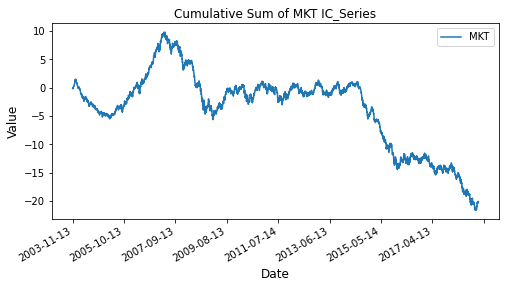

,IC,ICIR
MKT,-0.081245,-0.443427


In [768]:
## Plot Cumsum IC_Series of MKT
ax = IC_Series[['MKT']].cumsum().plot(title = 'Cumulative Sum of MKT IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.show()
pd.concat([all_ICs[["MKT"]],all_ICIRs[["MKT"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

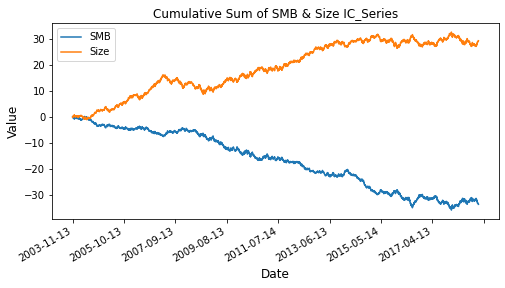

,IC,ICIR
SMB,-0.134966,-0.819604
Size,0.117714,0.620320


In [769]:
## Plot Cumsum IC_Series of SMB & Size
ax = IC_Series[["SMB","Size"]].cumsum().plot(title = 'Cumulative Sum of SMB & Size IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.show()
pd.concat([all_ICs[["SMB","Size"]],all_ICIRs[["SMB","Size"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

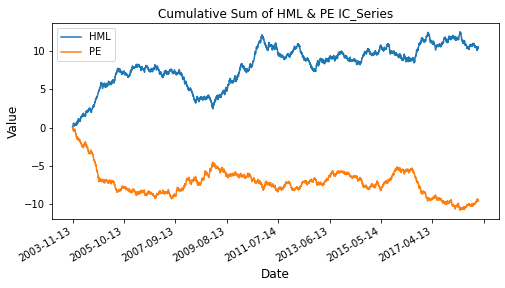

,IC,ICIR
HML,0.042314,0.442704
PE,-0.038471,-0.484595


In [770]:
## Plot Cumsum IC_Series of HML & PE
ax = IC_Series[["HML","PE"]].cumsum().plot(title = 'Cumulative Sum of HML & PE IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.show()
pd.concat([all_ICs[["HML","PE"]],all_ICIRs[["HML","PE"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

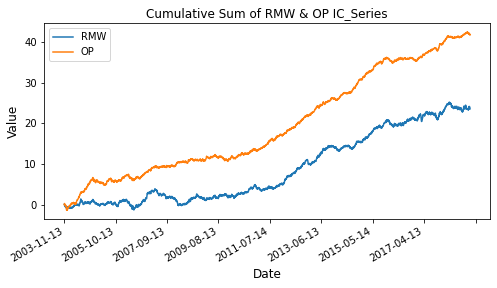

,IC,ICIR
RMW,0.094744,0.931786
OP,0.167967,2.220754


In [771]:
## Plot Cumsum IC_Series of RMW & OP
ax = IC_Series[["RMW","OP"]].cumsum().plot(title = 'Cumulative Sum of RMW & OP IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.show()
pd.concat([all_ICs[["RMW","OP"]],all_ICIRs[["RMW","OP"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

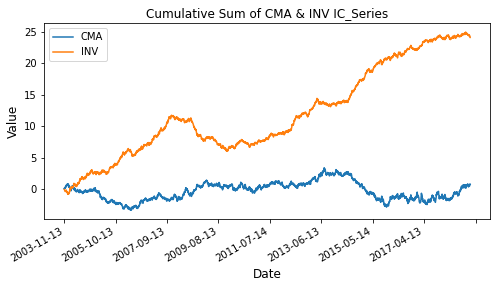

,IC,ICIR
CMA,0.003072,0.032335
INV,0.096828,1.354431


In [772]:
## Plot Cumsum IC_Series of CMA & INV
ax = IC_Series[["CMA","INV"]].cumsum().plot(title = 'Cumulative Sum of CMA & INV IC_Series',figsize = (8,4))
plt.gcf().autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.show()
pd.concat([all_ICs[["CMA","INV"]],all_ICIRs[["CMA","INV"]]],axis=1).rename(columns={0:'IC',1:'ICIR'})

Overall speaking, the factor risks under the CAPM, FF3-factor model or FF5-factor model are all unpriced in the cross-section of individual stock returns, while the slope coefficients of SIZE, PE and OP are statistically significant under the OLS and IV estimation, respectively. These findings suggest that firm characteristics could be the better choice for proxying the true unknown factor loadings since they have stronger explanatory power than beta estimates. In the following section, this study evaluates the possibility of using firm characteristics as factor loadings in empirical asset pricing models to replace time-varying betas without causing the EIV problem in the second stage of FM regression when using individual stocks as test assets. 

# Compare TS and CS models

This section use the cross-section regression approach of FM to construct cross-sectional factor (CS factors) corresponding to the time-series factors (TS factors) of Fama and French (2015).

## TS Factor Model I

In [773]:
df_FF3

,MR_RF,SMB,HML
Dates,,,
2000-12-20,-0.0083,0.001800,0.01275
2000-12-21,-0.0062,0.005367,-0.00005
2000-12-22,0.0163,-0.008000,-0.00260
2000-12-25,-0.0003,0.000000,0.00000
2000-12-26,-0.0003,0.000000,0.00000
...,...,...,...
2019-02-27,0.0008,-0.000800,0.00170
2019-02-28,-0.0055,-0.000567,-0.01845
2019-03-01,0.0034,-0.002067,0.01135


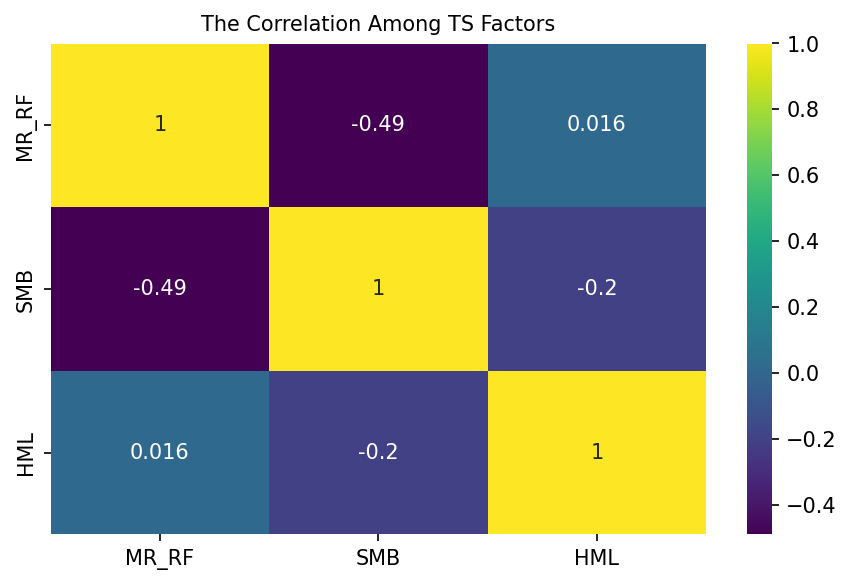

In [774]:
# Plot the correlation among FF3-Factor
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
corrMatrix = df_FF3.corr()
sn.heatmap(corrMatrix, annot=True, cmap="viridis")
plt.title('The Correlation Among TS Factors', fontsize=10)
plt.show()

TS factors are exactly the same as we used in FF5-Factor model

In [775]:
df_FF5

,MR_RF,SMB,HML,RMW,CMA
Dates,,,,,
2000-12-20,-0.0083,0.0065,0.0128,0.0040,-0.0019
2000-12-21,-0.0062,0.0030,-0.0000,-0.0009,0.0136
2000-12-22,0.0163,-0.0085,-0.0026,-0.0046,-0.0066
2000-12-25,-0.0003,0.0000,0.0000,0.0000,0.0000
2000-12-26,-0.0003,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...
2019-02-27,0.0008,0.0016,0.0017,-0.0080,-0.0027
2019-02-28,-0.0055,0.0014,-0.0185,0.0037,-0.0094
2019-03-01,0.0034,-0.0035,0.0113,-0.0043,-0.0053


Change the daily factor returns to monthly returns

In [776]:
m_df_FF5 = df_FF5
m_df_FF5['month'] = np.array(df_FF5.index.astype(str).str[:7])
m_df_FF5 = m_df_FF5.groupby('month').sum()
df_FF5 = df_FF5.drop(['month'], axis = 1)
# m_df_FF5 = m_df_FF5.iloc[:-1,:]
m_df_FF5

,MR_RF,SMB,HML,RMW,CMA
month,,,,,
2000-12,0.0107,0.0048,0.0088,-0.0139,0.0033
2001-01,0.0851,-0.0323,0.0297,0.0100,0.0152
2001-02,-0.0068,0.0359,0.0509,-0.0720,0.0064
2001-03,-0.0935,0.0446,0.0529,0.0163,0.0367
2001-04,0.0921,-0.0209,0.0041,-0.0210,0.0215
...,...,...,...,...,...
2018-11,-0.0365,-0.0061,-0.0031,0.0539,0.0140
2018-12,0.0375,-0.0062,0.0146,-0.0158,0.0412
2019-01,0.0234,-0.0454,0.0254,-0.0344,-0.0068


In [777]:
m_df_FF5.mean()*100

MR_RF    0.691045
SMB     -0.435818
HML      0.605273
RMW      0.554636
CMA     -0.191318
dtype: float64

In [778]:
m_df_FF5.std()

MR_RF    0.046434
SMB      0.026866
HML      0.029809
RMW      0.032577
CMA      0.033237
dtype: float64

In [779]:
m_df_FF5.apply(lambda x: stats.ttest_1samp(x,0))

,MR_RF,SMB,HML,RMW,CMA
0,2.207386,-2.406062,3.011696,2.525276,-0.853783
1,0.028325,0.016956,0.002903,0.012269,0.394158


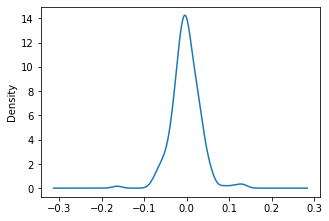

In [780]:
m_df_FF5.iloc[:,4].plot(kind='density')
# df_FF5.iloc[:,4].hist()
plt.show()

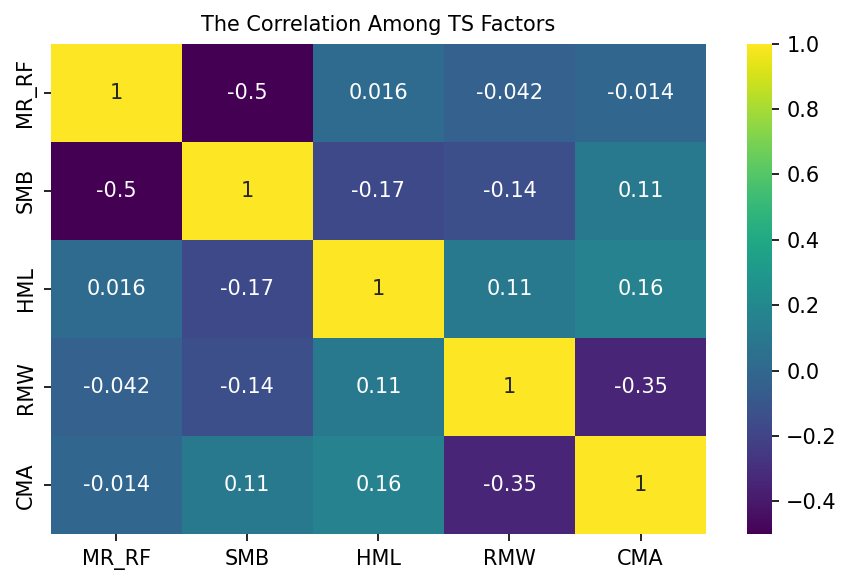

In [781]:
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
corrMatrix = df_FF5.corr()
sn.heatmap(corrMatrix, annot=True, cmap="viridis")
plt.title('The Correlation Among TS Factors', fontsize=10)
plt.show()

In [782]:
df_SR_tmp = df_SR.apply(replacer)
df_Ex_SR_tmp = df_SR_tmp - df_RF.values

Step-1: Use double-sorted portfolio return as regressors and then run time-series regression model to obtain factor loadings and interceptions, i.e. betas and alphas, with NW Adjustment

In [783]:
# Keep the excess stock returns and FF5-Factor returns have the same length
df_Ex_SR_trnct = df_Ex_SR_tmp.loc[df_FF5.index,:]

all_betas = []
all_cons_ts = []
all_std_errs = []
all_Rs = []
all_sd_res = []

betas = []
labels = []
cons_ts = []
std_errs = []
Rs = []
sd_res = []

for j in tqdm(df_Ex_SR.columns):

    df_index = (df_Ex_SR_trnct.loc[:, j].dropna().index).intersection(df_FF5.index)

    if len(df_index) > 10:
        lag = int(4*((len(df_Ex_SR_trnct.loc[df_index, j]))/100)**(1/9))
        ols = sm.OLS(df_Ex_SR_trnct.loc[df_index, j].astype(np.float64), sm.add_constant(
            df_FF5.loc[df_index, :].astype(np.float64)))
        res = ols.fit(cov_type='HAC', cov_kwds={'maxlags': lag})

        b = list(res.params)
        t = res.tvalues[0]
        se = res.bse[0]
        r = res.rsquared
        sr = res.resid.std()
        betas.append(b)
        cons_ts.append(t)
        std_errs.append(se)
        Rs.append(r)
        sd_res.append(sr)
        labels.append(j)

all_betas.append(pd.DataFrame(betas))
all_cons_ts.append(pd.DataFrame(cons_ts))
all_std_errs.append(pd.DataFrame(std_errs))
all_Rs.append(pd.DataFrame(Rs))
all_sd_res.append(pd.DataFrame(sd_res))

100%|██████████| 245/245 [00:01<00:00, 144.26it/s]


In [784]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AFT.SJ.Equity   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     8.828
Date:                Thu, 26 May 2022   Prob (F-statistic):           2.47e-08
Time:                        14:30:16   Log-Likelihood:                 7265.8
No. Observations:                3215   AIC:                        -1.452e+04
Df Residuals:                    3209   BIC:                        -1.448e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.718      0.473      -0.000       0.001
MR_RF          0.3136      0.056      5.596      0.000       0.204       0.423
SMB            0.3363      0.098      3.426      0.001       0.144       0.529
HML            0.1664      0.075      2.228      0.026       0.020       0.313
RMW            0.1977      0.078      2.549      0.011       0.046       0.350
CMA           -0.1236      0.080     -1.537      0.124      -0.281       0.034
==============================================================================
Omnibus:                     2355.859   Durbin-Watson:                   2.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           397352.300
Skew:                           2.557   Prob(JB):                         0.00
Kurtosis:                      57.223   Cond. No.                         191.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

In [785]:
TS_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
TS_betas.columns = ['Intercepts','MKT','SMB','HML','RMW','CMA','Stocks']
TS_betas = TS_betas.set_index('Stocks')
TS_betas

,Intercepts,MKT,SMB,HML,RMW,CMA
Stocks,,,,,,
FDS.SJ.Equity,-0.000369,0.340196,-0.463658,-0.159186,0.134961,-1.240993
MOZ.SJ.Equity,0.000722,0.379325,-0.907089,-0.234191,-0.408139,0.162979
MTN.SJ.Equity,-0.000357,0.840304,-0.520205,0.010708,0.136745,0.034752
TRT.SJ.Equity,0.000357,0.273325,0.397549,0.170816,0.170808,-0.320418
AEG.SJ.Equity,-0.001385,0.604049,-0.174283,0.062281,-0.181758,0.011086
...,...,...,...,...,...,...
MTH.SJ.Equity,-0.001209,1.201893,0.270604,0.027184,0.016987,-0.084403
DIA.SJ.Equity,-0.000010,0.325877,0.333844,0.463869,-0.385987,-0.432324
CTK.SJ.Equity,0.000304,0.314548,0.486037,0.051498,0.306129,-0.067770


In [786]:
## The alphas are missing pricing errors of asset pricing model (FF5-Factor), which are also the intercepts of time series regression
TS_alphas = TS_betas.iloc[:,0]
TS_alphas.describe()

count    243.000000
mean      -0.000099
std        0.001013
min       -0.007418
25%       -0.000278
50%        0.000033
75%        0.000291
max        0.002908
Name: Intercepts, dtype: float64

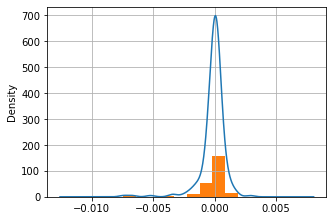

In [787]:
TS_alphas.plot(kind='density')
TS_alphas.hist()
plt.show()

In [788]:
all_cons_ts[0]

,0
0,-0.073938
1,0.906040
2,-1.333854
3,0.763192
4,-2.892179
...,...
238,-0.461102
239,-0.022141
240,0.579802
241,0.056743


In [789]:
all_ses = pd.DataFrame(all_std_errs[0])
all_ses.index = TS_alphas.index
all_ses.columns = ['std_errs']
all_ses

,std_errs
Stocks,
FDS.SJ.Equity,0.004991
MOZ.SJ.Equity,0.000797
MTN.SJ.Equity,0.000268
TRT.SJ.Equity,0.000467
AEG.SJ.Equity,0.000479
...,...
MTH.SJ.Equity,0.002621
DIA.SJ.Equity,0.000464
CTK.SJ.Equity,0.000524


In [790]:
TS_alphas_t = pd.concat([all_cons_ts[0], pd.DataFrame(labels)], axis = 1)
TS_alphas_t.columns = ['t-statistics','Stocks']
TS_alphas_t = TS_alphas_t.set_index('Stocks')
TS_alphas_t

,t-statistics
Stocks,
FDS.SJ.Equity,-0.073938
MOZ.SJ.Equity,0.906040
MTN.SJ.Equity,-1.333854
TRT.SJ.Equity,0.763192
AEG.SJ.Equity,-2.892179
...,...
MTH.SJ.Equity,-0.461102
DIA.SJ.Equity,-0.022141
CTK.SJ.Equity,0.579802


### Results_1

Step2: Calculate the absolute value of alphas and alphas_t, then calculate their mean respectively

In [791]:
print(np.mean(abs(TS_alphas))*21*100,np.nanmean(abs(TS_alphas_t)))

1.1296091198447655 0.869320217536284


Step3: Calculate the cross-sectional variance of LHS average returns and then divided by the mean of squared alphas

In [792]:
cs_var = np.var(df_SR_tmp.apply(lambda x: np.mean(x), axis = 0))
print(np.mean(np.square(TS_alphas))/cs_var)

1.2787560332717343


Step4: Substract the squared standard error of each intercept to adjust for the noise in the Step-3

In [793]:
A_lamda = np.mean((pd.DataFrame(np.square(TS_alphas).values)-pd.DataFrame(np.square(all_ses).values)), axis = 0)
print(A_lamda/cs_var)

0    0.188094
dtype: float64


Step5: the average of the regression R^2; the average of the standard errors of the intercepts; the average of the standard deviations of the regression residuals.

In [794]:
print('AR^2: ' + str(np.mean(all_Rs)), 'As(a): ' + str(np.mean(all_ses.values)*np.sqrt(21)), \
      'As(e): ' + str(np.mean(all_sd_res)*np.sqrt(21)))

AR^2: 0.07341949673070357 As(a): 0.0028170667498644284 As(e): 0.14274028600198713


Step6: Calculate Cross-sectional R-squared, how much the total variance of expected stock returns can be explained by the model?

In [795]:
1-(np.var(TS_alphas)/np.var(df_Ex_SR_tmp.mean()))

-0.25054544744525886

## CS Factor Model I

Import 18 double-sorted portfolios returns

In [796]:
df_18_PR

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,0.0062,-0.0079,-0.0238,-0.0114,-0.0021,-0.0140,-0.0069,-0.0123,-0.0179,-0.0047,-0.0152,-0.0002,0.0033,-0.0070,-0.0022,-0.0171,0.0022,-0.0024
2000-12-21,-0.0069,-0.0137,0.0024,-0.0046,-0.0139,-0.0037,-0.0023,-0.0043,-0.0035,-0.0008,0.0087,-0.0100,-0.0021,-0.0010,-0.0011,0.0183,-0.0127,-0.0077
2000-12-22,0.0112,0.0131,0.0152,0.0138,0.0108,0.0159,0.0038,0.0176,0.0195,0.0058,0.0027,0.0070,0.0029,0.0097,0.0099,0.0004,0.0108,-0.0022
2000-12-25,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2000-12-26,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,0.0084,-0.0003,0.0063,0.0023,0.0040,0.0097,0.0082,0.0021,0.0017,0.0098,-0.0063,0.0085,0.0014,0.0079,0.0100,0.0055,0.0006,0.0174
2019-02-28,-0.0125,-0.0073,0.0017,-0.0193,-0.0027,0.0023,-0.0019,-0.0030,-0.0082,-0.0157,-0.0111,0.0070,0.0060,-0.0083,-0.0230,-0.0230,-0.0034,0.0022
2019-03-01,0.0065,0.0013,-0.0041,-0.0022,0.0029,-0.0007,-0.0001,0.0014,-0.0029,-0.0033,0.0162,-0.0154,-0.0051,-0.0051,0.0020,-0.0085,-0.0009,0.0049


Import Firm Characteristics of 18 double-sorted portfolios

In [797]:
df_18_std_Size

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,0.942657,0.357455,0.892459,1.986398,0.069024,0.374104,0.048000,0.069849,2.345359,-0.805869,-0.739840,-0.815606,-0.798091,-0.767378,-0.820553,-0.734375,-0.837613,-0.765981
2000-12-21,0.942657,0.357455,0.892459,1.986398,0.069024,0.374104,0.048000,0.069849,2.345359,-0.805869,-0.739840,-0.815606,-0.798091,-0.767378,-0.820553,-0.734375,-0.837613,-0.765981
2000-12-22,0.942657,0.357455,0.892459,1.986398,0.069024,0.374104,0.048000,0.069849,2.345359,-0.805869,-0.739840,-0.815606,-0.798091,-0.767378,-0.820553,-0.734375,-0.837613,-0.765981
2000-12-25,0.948072,0.362528,0.889354,1.990243,0.071630,0.371886,0.046339,0.068151,2.339770,-0.806071,-0.740154,-0.815790,-0.798306,-0.767645,-0.820957,-0.734698,-0.838101,-0.766250
2000-12-26,0.951308,0.365563,0.887493,1.992536,0.073189,0.370557,0.045345,0.067134,2.336418,-0.806188,-0.740340,-0.815898,-0.798432,-0.767802,-0.821196,-0.734889,-0.838391,-0.766408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,0.427582,1.032318,1.219934,1.249520,1.208213,0.340078,0.473927,1.322083,1.136259,-0.953475,-0.906959,-0.932339,-0.908835,-0.927355,-0.972487,-0.962794,-0.928556,-0.917113
2019-02-28,0.427652,1.032304,1.219936,1.249485,1.208191,0.340011,0.473718,1.322217,1.136320,-0.953472,-0.906947,-0.932325,-0.908820,-0.927342,-0.972489,-0.962786,-0.928548,-0.917105
2019-03-01,0.427722,1.032289,1.219937,1.249450,1.208169,0.339945,0.473512,1.322350,1.136381,-0.953470,-0.906935,-0.932311,-0.908805,-0.927329,-0.972491,-0.962778,-0.928541,-0.917096


In [798]:
df_18_std_PE

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,-0.900659,-0.411347,0.551820,-0.122545,-0.400719,-0.190703,-0.432970,-0.016427,0.069313,-0.782024,-0.352475,2.203033,-0.418637,-0.689674,2.894326,-0.397909,-0.721700,0.119299
2000-12-21,-0.895906,-0.416109,0.546832,-0.126412,-0.405572,-0.186008,-0.432607,-0.018843,0.063027,-0.777771,-0.344896,2.191835,-0.420100,-0.687900,2.908686,-0.381971,-0.723272,0.106988
2000-12-22,-0.892946,-0.420407,0.546203,-0.129412,-0.406900,-0.184194,-0.434744,-0.017081,0.067775,-0.774850,-0.344973,2.186750,-0.421400,-0.687031,2.914790,-0.379626,-0.719047,0.097090
2000-12-25,-0.891487,-0.422514,0.545891,-0.130884,-0.407549,-0.183302,-0.435790,-0.016215,0.070105,-0.773411,-0.345008,2.184242,-0.422036,-0.686601,2.917770,-0.378472,-0.716969,0.092230
2000-12-26,-0.890619,-0.423765,0.545705,-0.131759,-0.407934,-0.182772,-0.436411,-0.015701,0.071490,-0.772554,-0.345029,2.182747,-0.422413,-0.686344,2.919536,-0.377786,-0.715732,0.089342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-1.087697,-0.739813,2.201939,-0.572948,0.312987,1.732538,0.938174,-0.473959,0.888074,-1.057970,-0.824239,1.117544,-0.831072,-0.665375,0.276073,0.049502,-0.487887,-0.775871
2019-02-28,-1.089170,-0.740504,2.200315,-0.573356,0.310967,1.731917,0.936775,-0.474267,0.885956,-1.056867,-0.825013,1.120994,-0.831928,-0.666265,0.281049,0.052721,-0.487457,-0.775867
2019-03-01,-1.090631,-0.741182,2.198695,-0.573756,0.308963,1.731299,0.935382,-0.474563,0.883848,-1.055763,-0.825769,1.124400,-0.832776,-0.667165,0.285998,0.055933,-0.487060,-0.775852


In [799]:
df_18_std_OP

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,-0.305114,0.108086,-0.008410,1.009224,-0.371517,-1.003130,-0.204715,-0.431790,0.575749,0.222890,1.100296,0.595127,1.810449,-0.254222,-2.255018,-1.781615,0.247647,0.946063
2000-12-21,-0.305114,0.108086,-0.008410,1.009224,-0.371517,-1.003130,-0.204715,-0.431790,0.575749,0.222890,1.100296,0.595127,1.810449,-0.254222,-2.255018,-1.781615,0.247647,0.946063
2000-12-22,-0.305114,0.108086,-0.008410,1.009224,-0.371517,-1.003130,-0.204715,-0.431790,0.575749,0.222890,1.100296,0.595127,1.810449,-0.254222,-2.255018,-1.781615,0.247647,0.946063
2000-12-25,-0.309103,0.109622,-0.012920,1.013839,-0.376368,-1.010133,-0.209717,-0.437361,0.572703,0.218960,1.098564,0.592129,1.810496,-0.259348,-2.238501,-1.790568,0.283763,0.943944
2000-12-26,-0.311488,0.110541,-0.015636,1.016564,-0.379269,-1.014296,-0.212719,-0.440693,0.570836,0.216580,1.097460,0.590291,1.810425,-0.262422,-2.228430,-1.795864,0.305503,0.942616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,0.047384,0.169347,0.115514,0.973985,-0.092869,-0.424752,-0.035035,0.132169,0.216665,-1.170871,1.192086,0.007795,1.687556,0.090273,-2.398853,-1.788791,0.231200,1.047197
2019-02-28,0.050689,0.169590,0.116233,0.974381,-0.092427,-0.422251,-0.032406,0.132580,0.216818,-1.172467,1.191647,0.006432,1.686716,0.089356,-2.400595,-1.788657,0.230136,1.044228
2019-03-01,0.053965,0.169830,0.116945,0.974771,-0.091989,-0.419770,-0.029799,0.132988,0.216970,-1.174046,1.191208,0.005080,1.685878,0.088446,-2.402317,-1.788520,0.229081,1.041281


In [800]:
df_18_std_INV

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,-0.320455,-0.725071,0.328962,0.283652,-0.461130,-0.336654,-1.241484,-0.429337,1.740570,-0.590169,-0.322096,2.295917,0.271474,0.841033,-0.964468,-1.223396,-0.524202,1.376856
2000-12-21,-0.320455,-0.725071,0.328962,0.283652,-0.461130,-0.336654,-1.241484,-0.429337,1.740570,-0.590169,-0.322096,2.295917,0.271474,0.841033,-0.964468,-1.223396,-0.524202,1.376856
2000-12-22,-0.320455,-0.725071,0.328962,0.283652,-0.461130,-0.336654,-1.241484,-0.429337,1.740570,-0.590169,-0.322096,2.295917,0.271474,0.841033,-0.964468,-1.223396,-0.524202,1.376856
2000-12-25,-0.320533,-0.725170,0.328917,0.283605,-0.461215,-0.336733,-1.241609,-0.429420,1.740597,-0.590261,-0.322174,2.295972,0.271426,0.841015,-0.963928,-1.223520,-0.523835,1.376865
2000-12-26,-0.320580,-0.725229,0.328890,0.283577,-0.461266,-0.336780,-1.241684,-0.429470,1.740613,-0.590316,-0.322221,2.296005,0.271398,0.841003,-0.963604,-1.223594,-0.523615,1.376870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-0.825316,0.038799,0.043991,0.350256,-0.155431,1.521690,-0.786766,-0.234443,2.077403,-0.522005,0.758385,-0.536770,0.488227,-0.304769,-1.148009,-1.938079,-0.317630,1.490467
2019-02-28,-0.827368,0.040026,0.044361,0.350750,-0.154578,1.521070,-0.787155,-0.233373,2.077826,-0.522573,0.757679,-0.535676,0.488224,-0.305047,-1.148364,-1.937715,-0.317974,1.489889
2019-03-01,-0.829404,0.041245,0.044729,0.351240,-0.153731,1.520453,-0.787542,-0.232311,2.078244,-0.523137,0.756978,-0.534591,0.488221,-0.305323,-1.148714,-1.937353,-0.318316,1.489313


Step-1: Use 18 (3*6) doubt-sorted portfolios as test assets and run CS regression to obtain R_zt and four pure factor returns;

In [801]:
all_lambdas = []
all_intercepts = []

lambdas = []
intercepts = []
Dates = []
index_times = list(df_18_PR.T.columns)

for k in tqdm(df_18_PR.T.columns):

    df_index = ((((df_18_std_Size.T.loc[:, k].replace(-np.inf, np.nan).dropna().index).
                 intersection(df_18_std_PE.T.loc[:, k].replace(-np.inf, np.nan).dropna().index)).
                 intersection(df_18_PR.T.loc[:, index_times[index_times.index(k)]].dropna().index)).
                intersection(df_18_std_OP.T.loc[:, k].dropna().index)).\
        intersection(df_18_std_INV.T.loc[:, k].dropna().index)

    if len(df_index) > 10:

        l = list(ols_model.fit((pd.concat([df_18_std_Size.T.loc[df_index, k],
                                           df_18_std_PE.T.loc[df_index, k],
                                           df_18_std_OP.T.loc[df_index, k],
                                           df_18_std_INV.T.loc[df_index, k]], axis=1).values),
                               (df_18_PR.T.loc[df_index, index_times[index_times.index(k)]].values)).coef_)

        h = ols_model.fit((pd.concat([df_18_std_Size.T.loc[df_index, k],
                                      df_18_std_PE.T.loc[df_index, k],
                                      df_18_std_OP.T.loc[df_index, k],
                                      df_18_std_INV.T.loc[df_index, k]], axis=1).values),
                          (df_18_PR.T.loc[df_index, index_times[index_times.index(k)]].values)).intercept_

        lambdas.append(l)
        intercepts.append(h)
        Dates.append(k)

all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 4750/4750 [00:24<00:00, 193.76it/s]


In [802]:
## Through performing FM-2 at each time t, we got the pure factor return time-series for MC/PE/OP/INV and intercept (Rzt)
df_CS_FF4 = pd.concat([all_lambdas[0], pd.DataFrame(Dates)], axis = 1)
df_CS_FF4.columns = ['Size','PE','OP','INV','Dates']
df_CS_FF4 = df_CS_FF4.set_index(['Dates'])
df_CS_FF4

,Size,PE,OP,INV
Dates,,,,
2000-12-20,-0.003496,0.000332,0.001952,-0.000357
2000-12-21,-0.000954,-0.000732,-0.001852,-0.000648
2000-12-22,0.004393,0.000246,-0.001754,0.000570
2000-12-25,0.000000,0.000000,0.000000,0.000000
2000-12-26,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
2019-02-27,-0.001402,0.000836,-0.002045,0.001005
2019-02-28,-0.002140,0.005767,0.007298,-0.000513
2019-03-01,0.001442,-0.003470,-0.000897,0.002338


In [803]:
df_Rzt = pd.concat([all_intercepts[0], pd.DataFrame(Dates)], axis = 1)
df_Rzt.columns = ['Rzt','Dates']
df_Rzt = df_Rzt.set_index(['Dates'])
df_Rzt

,Rzt
Dates,
2000-12-20,-0.007411
2000-12-21,-0.003272
2000-12-22,0.009328
2000-12-25,0.000000
2000-12-26,0.000000
...,...
2019-02-27,0.005400
2019-02-28,-0.006678
2019-03-01,-0.000728


In [804]:
df_18_PR.T.mean()

Dates
2000-12-20   -0.007411
2000-12-21   -0.003272
2000-12-22    0.009328
2000-12-25    0.000000
2000-12-26    0.000000
                ...   
2019-02-27    0.005400
2019-02-28   -0.006678
2019-03-01   -0.000728
2019-03-04   -0.005822
2019-03-05   -0.006606
Length: 4750, dtype: float64

In [805]:
df_18_CS = pd.concat([df_Rzt, df_CS_FF4], axis = 1)
df_18_CS

,Rzt,Size,PE,OP,INV
Dates,,,,,
2000-12-20,-0.007411,-0.003496,0.000332,0.001952,-0.000357
2000-12-21,-0.003272,-0.000954,-0.000732,-0.001852,-0.000648
2000-12-22,0.009328,0.004393,0.000246,-0.001754,0.000570
2000-12-25,0.000000,0.000000,0.000000,0.000000,0.000000
2000-12-26,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2019-02-27,0.005400,-0.001402,0.000836,-0.002045,0.001005
2019-02-28,-0.006678,-0.002140,0.005767,0.007298,-0.000513
2019-03-01,-0.000728,0.001442,-0.003470,-0.000897,0.002338


In [806]:
m_df_18_CS = df_18_CS
m_df_18_CS['month'] = np.array(df_18_CS.index.astype(str).str[:7])
m_df_18_CS = m_df_18_CS.groupby('month').sum()
df_18_CS = df_18_CS.drop(['month'], axis = 1)
m_df_18_CS

,Rzt,Size,PE,OP,INV
month,,,,,
2000-12,0.017300,-0.000109,0.005284,-0.001102,-0.002467
2001-01,0.054800,0.007398,-0.001684,0.010093,-0.020373
2001-02,-0.024672,-0.014028,-0.001771,-0.006750,-0.007083
2001-03,-0.066872,-0.026997,-0.024022,0.005506,0.003115
2001-04,0.051144,0.018261,0.009289,-0.014639,-0.003776
...,...,...,...,...,...
2018-11,-0.024828,0.003408,-0.002583,0.004042,-0.006286
2018-12,-0.002978,0.001941,0.004501,-0.000882,-0.008516
2019-01,-0.004572,0.021708,-0.000672,-0.008871,0.005912


In [807]:
m_df_18_CS.mean()*100

Rzt     0.174798
Size    0.114967
PE     -0.154457
OP      0.154877
INV     0.048239
dtype: float64

In [808]:
m_df_18_CS.std()

Rzt     0.037296
Size    0.014578
PE      0.010008
OP      0.011347
INV     0.008696
dtype: float64

In [809]:
m_df_18_CS.apply(lambda x: stats.ttest_1samp(x,0))

,Rzt,Size,PE,OP,INV
0,0.695170,1.169743,-2.289247,2.024422,0.822751
1,0.487686,0.243376,0.023018,0.044141,0.411545


In [810]:
df_18_CS.apply(lambda x: stats.ttest_1samp(x,0))

,Rzt,Size,PE,OP,INV
0,0.960442,1.036108,-2.299161,1.735116,0.696593
1,0.336881,0.300205,0.021539,0.082785,0.486091


Step-2: (Mis-Pricing error at each time t)-> alpha,it = R,it - (Rz,t + firm characteristics,i*lambda,t), t=1,2,3,...,T, 

In [811]:
df_ln_Size = df_ln_Size_trnct
df_std_PE = df_PE_trnct
df_std_OP = df_OP_trnct
df_std_INV = df_INV_trnct

In [812]:
len(df_ln_Size)==len(df_std_PE)==len(df_std_OP)==len(df_std_INV)

True

In [813]:
# Constant Version of CS factor model I
# (average beta) * lambda + Rz
# Prediction = df_ln_Size.apply(lambda x: np.mean(x) * df_CS_FF4.iloc[:,0])+\
# df_std_PE.apply(lambda x: np.mean(x) * df_CS_FF4.iloc[:,1])+\
# df_std_OP.apply(lambda x: np.mean(x) * df_CS_FF4.iloc[:,2])+\
# df_std_INV.apply(lambda x: np.mean(x) * df_CS_FF4.iloc[:,3])

In [814]:
# Time-varying Version of CS factor model I
# beta * lambda + Rz
Prediction = df_ln_Size.apply(lambda x: x * df_CS_FF4.iloc[:,0])+\
df_std_PE.apply(lambda x: x * df_CS_FF4.iloc[:,1])+\
df_std_OP.apply(lambda x: x * df_CS_FF4.iloc[:,2])+\
df_std_INV.apply(lambda x: x * df_CS_FF4.iloc[:,3])

In [815]:
intc_index = df_SR.index.intersection(Prediction.index)
intc_columns = df_SR.columns.intersection(Prediction.columns)

In [816]:
Prediction.loc[intc_index,intc_columns]

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,NaN,-0.003530,-0.010683,0.005502,NaN,NaN,0.000069,-0.001313,-0.002432,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-21,NaN,0.000526,-0.005016,-0.001295,NaN,NaN,0.000284,-0.001390,0.000100,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-22,NaN,0.003870,0.014254,-0.006301,NaN,NaN,-0.000340,0.001795,0.002763,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-25,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-26,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,NaN,-0.001547,-0.003061,-0.000520,0.000929,-0.001937,-0.001933,0.001192,-0.002525,-0.003388,...,-0.000954,-0.000285,NaN,NaN,NaN,NaN,-0.000068,-0.001484,-0.000272,-0.000647
2019-02-28,NaN,0.000665,-0.003168,0.004459,-0.002414,0.000195,0.002661,0.002055,-0.002471,-0.005375,...,-0.000690,-0.001675,NaN,NaN,NaN,NaN,-0.001293,0.003321,-0.001848,0.001187
2019-03-01,NaN,-0.001748,0.002556,0.001674,-0.000614,0.001609,-0.000504,-0.000535,0.002530,0.003924,...,-0.000505,0.001756,NaN,NaN,NaN,NaN,0.000905,0.000468,0.001159,0.000250


In [817]:
df_SR_tmp.loc[intc_index,intc_columns]

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,-0.011211,-0.117783,-0.026088,0.0,-0.007551,0.000000,0.030772,-0.057759,-0.003556,0.002107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-21,-0.049637,-0.068993,-0.017778,0.0,0.000000,-0.013129,-0.020409,-0.055570,-0.010633,-0.014847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-22,0.044758,0.017700,0.073467,0.0,0.001541,0.000000,0.000000,0.055570,0.017697,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-25,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-26,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,NaN,NaN,-0.000829,NaN,0.000000,NaN,-0.017486,NaN,-0.002816,0.019041,...,0.045120,0.003494,-0.057679,NaN,0.014148,0.052096,0.000000,0.006645,0.006842,0.043952
2019-02-28,NaN,NaN,-0.010837,NaN,0.288878,NaN,-0.002748,NaN,-0.006529,0.008386,...,-0.019803,0.000498,0.006231,-0.009097,0.015452,0.007431,0.009941,0.000000,0.000000,-0.006689
2019-03-01,NaN,NaN,-0.055638,NaN,-0.288878,NaN,0.004315,NaN,0.007396,-0.004710,...,0.000000,-0.000498,-0.006231,-0.064075,0.036975,-0.006652,0.006275,0.001985,0.014291,-0.018629


After obtaining the return prediction of each stock i at each time t, we now can calculate the mis-pricing errors of CS factor models by using real stock time subtract its corresponding prediction return

In [818]:
df_alphas = df_SR_tmp.loc[intc_index,intc_columns].apply(lambda x: x - df_Rzt.iloc[:,0]) - Prediction.loc[intc_index,intc_columns]
df_alphas

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,NaN,-0.106842,-0.007994,0.001909,NaN,NaN,0.038113,-0.049035,0.006287,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-21,NaN,-0.066246,-0.009490,0.004567,NaN,NaN,-0.017421,-0.050908,-0.007462,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-22,NaN,0.004502,0.049886,-0.003026,NaN,NaN,-0.008987,0.044447,0.005606,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-25,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-26,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,NaN,NaN,-0.003168,NaN,-0.006329,NaN,-0.020953,NaN,-0.005691,0.017029,...,0.040675,-0.001621,NaN,NaN,NaN,NaN,-0.005332,0.002729,0.001713,0.039199
2019-02-28,NaN,NaN,-0.000990,NaN,0.297969,NaN,0.001269,NaN,0.002620,0.020439,...,-0.012435,0.008850,NaN,NaN,NaN,NaN,0.017912,0.003357,0.008526,-0.001198
2019-03-01,NaN,NaN,-0.057466,NaN,-0.287536,NaN,0.005546,NaN,0.005594,-0.007906,...,0.001233,-0.001526,NaN,NaN,NaN,NaN,0.006098,0.002244,0.013860,-0.018151


Step-3: Use t.test to Calculate the time-series mean of alpha,it and obtain their corresponding t-statistics

In [819]:
TSmean_alphas = df_alphas.apply(lambda x: np.mean(x))
TSmean_alphas.describe()

count    224.000000
mean       0.000038
std        0.001056
min       -0.009288
25%       -0.000066
50%        0.000241
75%        0.000468
max        0.001496
dtype: float64

In [820]:
tstats_alphas = df_alphas.apply(lambda x: np.NaN if np.all(x!=x) else stats.ttest_1samp(x,0.0,nan_policy='omit')[0])
tstats_alphas = pd.DataFrame(tstats_alphas)
tstats_alphas.T

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
0,NaN,0.34359,0.181712,0.60263,-1.86688,2.721472,2.333276,-0.395809,1.728562,0.787348,...,-1.57735,1.854258,NaN,NaN,NaN,NaN,0.404044,1.192134,1.961063,1.58079


In [821]:
# calculate the percentage of NAs in Alphas
np.sum(df_alphas.apply(lambda x: np.isnan(x).sum()==len(x), axis = 0))/df_alphas.shape[1]

0.08571428571428572

Step-4: Alpha Test: Calcualte the mean of abs(alphas,i) and abs(t.statistic_alphas,i) 

### Results_2

In [822]:
### Calculate the absolute value of alphas and alphas_t, then calculate their mean respectively
print(np.mean(abs(TSmean_alphas))*21*100,np.nanmean(abs(tstats_alphas)))

1.1927177129334685 0.9299935367804942


In [823]:
### Calculate the squared alphas and then divided by the cross-sectional variance of LHS average returns  
cs_var = np.var(df_SR_tmp.apply(lambda x: np.mean(x), axis = 0))
print(np.mean(np.square(TSmean_alphas))/cs_var)

1.3775635849217065


In [824]:
### Substract the squared standard error of each intercept to adjust for the noise in the Step-3
alphas_se = df_alphas.apply(lambda x: np.std(x)/np.sqrt(len(x)))
A_lamda = np.mean((pd.DataFrame(np.square(TSmean_alphas).values)-pd.DataFrame(np.square(alphas_se).values)), axis = 0)
print(A_lamda/cs_var)

0    1.026451
dtype: float64


In [825]:
## calculate the time-series regression R-squared for model i (i <- 0~[N-1])
# SST1 = np.square(df_Ex_SR.iloc[:,1] - df_Ex_SR.iloc[:,1].mean()).sum()
# SS_res1 = np.square(df_alphas.iloc[:,1]).mean()
# R_sqr1 = 1 - (SS_res1/SST1)
# R_sqr1 

In [826]:
## loop the above procedure
SST = np.square(df_SR_tmp.apply(lambda x: x-np.mean(x))).sum()
SS_res = np.square(df_alphas).mean()
R_sqr = 1 - SS_res/SST

In [827]:
#### calculate the time-series R^2 for CS factor model I
SST_1 = np.square(df_SR_tmp.apply(lambda x: x-np.mean(x))).sum()
R_sqrt = 1-((np.square(df_alphas).mean())/SST_1)

In [828]:
R_sqrt.describe()

count    224.000000
mean       0.999625
std        0.000440
min        0.995646
25%        0.999545
50%        0.999794
75%        0.999845
max        0.999992
dtype: float64

In [829]:
alpha_ses = df_alphas.apply(lambda x: np.NaN if np.all(x!=x) else np.std(x)/np.sqrt(len(x)))
alpha_sds =  df_alphas.apply(lambda x: np.NaN if np.all(x!=x) else np.std(x))

In [830]:
### the average of the regression R^2; the average of the standard errors of the intercepts; 
### the average of the standard deviations of the regression residuals.
print('AR^2: ' + str(np.nanmean(R_sqr.values)), 'As(a): ' + str(np.mean(alpha_ses)*np.sqrt(21)), \
      'As(e): ' + str(np.mean(alpha_sds)*np.sqrt(21)))

AR^2: 0.999625044150435 As(a): 0.0019033282969513725 As(e): 0.131177850182053


In [831]:
## Calculate Cross-sectional R-squared, how much the total variance of expected stock returns can be explained by the model?
1-(np.var(df_alphas.mean())/np.var(df_Ex_SR_tmp.mean()))

-0.3583274761176143

### Cross-section Factor Model II

In [832]:
## Step-1: Use firm characteristics as factor loadings in FM-2 regression and get the pure factor returns 
## Step-2: Use pure factor return from step-1 and run time-series regression get cross-sectional betas and alphas(mis-pricing errors), with NW Adjustment
## Step-3: Alpha Test: Calcualte the mean of abs(alphas,i) and abs(t.statistic_alphas,i) 

In [833]:
## Through FM cross-sectional regression, we got the pure factor return of MC/PE/OP/INV
df_CS_FF4

,Size,PE,OP,INV
Dates,,,,
2000-12-20,-0.003496,0.000332,0.001952,-0.000357
2000-12-21,-0.000954,-0.000732,-0.001852,-0.000648
2000-12-22,0.004393,0.000246,-0.001754,0.000570
2000-12-25,0.000000,0.000000,0.000000,0.000000
2000-12-26,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
2019-02-27,-0.001402,0.000836,-0.002045,0.001005
2019-02-28,-0.002140,0.005767,0.007298,-0.000513
2019-03-01,0.001442,-0.003470,-0.000897,0.002338


In [834]:
## Test FF5CS-Factor Asset Pricing Models by using TS Regression

In [835]:
df_MR

,MR_RF
Dates,
2000-01-05,-0.0108
2000-01-06,0.0012
2000-01-07,0.0248
2000-01-10,0.0323
2000-01-11,0.0024
...,...
2019-12-25,-0.0002
2019-12-26,-0.0002
2019-12-27,0.0031


In [836]:
df_CS_FF5 = pd.concat([df_MR.loc[df_CS_FF4.index,:], df_CS_FF4], axis = 1)
df_CS_FF5 = df_CS_FF5.rename(columns={'Size':'MC'})
df_CS_FF5

,MR_RF,MC,PE,OP,INV
Dates,,,,,
2000-12-20,-0.0083,-0.003496,0.000332,0.001952,-0.000357
2000-12-21,-0.0062,-0.000954,-0.000732,-0.001852,-0.000648
2000-12-22,0.0163,0.004393,0.000246,-0.001754,0.000570
2000-12-25,-0.0003,0.000000,0.000000,0.000000,0.000000
2000-12-26,-0.0003,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2019-02-27,0.0008,-0.001402,0.000836,-0.002045,0.001005
2019-02-28,-0.0055,-0.002140,0.005767,0.007298,-0.000513
2019-03-01,0.0034,0.001442,-0.003470,-0.000897,0.002338


In [837]:
m_df_CS_FF5 = df_CS_FF5
m_df_CS_FF5['month'] = np.array(df_CS_FF5.index.astype(str).str[:7])
m_df_CS_FF5 = m_df_CS_FF5.groupby('month').sum()
df_CS_FF5 = df_CS_FF5.drop(['month'], axis = 1)
m_df_CS_FF5

,MR_RF,MC,PE,OP,INV
month,,,,,
2000-12,0.0107,-0.000109,0.005284,-0.001102,-0.002467
2001-01,0.0851,0.007398,-0.001684,0.010093,-0.020373
2001-02,-0.0068,-0.014028,-0.001771,-0.006750,-0.007083
2001-03,-0.0935,-0.026997,-0.024022,0.005506,0.003115
2001-04,0.0921,0.018261,0.009289,-0.014639,-0.003776
...,...,...,...,...,...
2018-11,-0.0365,0.003408,-0.002583,0.004042,-0.006286
2018-12,0.0375,0.001941,0.004501,-0.000882,-0.008516
2019-01,0.0234,0.021708,-0.000672,-0.008871,0.005912


In [838]:
m_df_CS_FF5.mean()*100

MR_RF    0.691045
MC       0.114967
PE      -0.154457
OP       0.154877
INV      0.048239
dtype: float64

In [839]:
m_df_CS_FF5.std()

MR_RF    0.046434
MC       0.014578
PE       0.010008
OP       0.011347
INV      0.008696
dtype: float64

In [840]:
m_df_CS_FF5.apply(lambda x: stats.ttest_1samp(x,0))

,MR_RF,MC,PE,OP,INV
0,2.207386,1.169743,-2.289247,2.024422,0.822751
1,0.028325,0.243376,0.023018,0.044141,0.411545


In [841]:
df_CS_FF5.apply(lambda x: stats.ttest_1samp(x, 0), axis=0)

,MR_RF,MC,PE,OP,INV
0,1.898812,1.036108,-2.299161,1.735116,0.696593
1,0.057650,0.300205,0.021539,0.082785,0.486091


In [842]:
df_CS_FF5.corr()

,MR_RF,MC,PE,OP,INV
MR_RF,1.000000,0.494478,0.081469,-0.111215,-0.005922
MC,0.494478,1.000000,0.099486,-0.252728,0.285595
PE,0.081469,0.099486,1.000000,0.124224,0.052068
OP,-0.111215,-0.252728,0.124224,1.000000,-0.181766
INV,-0.005922,0.285595,0.052068,-0.181766,1.000000


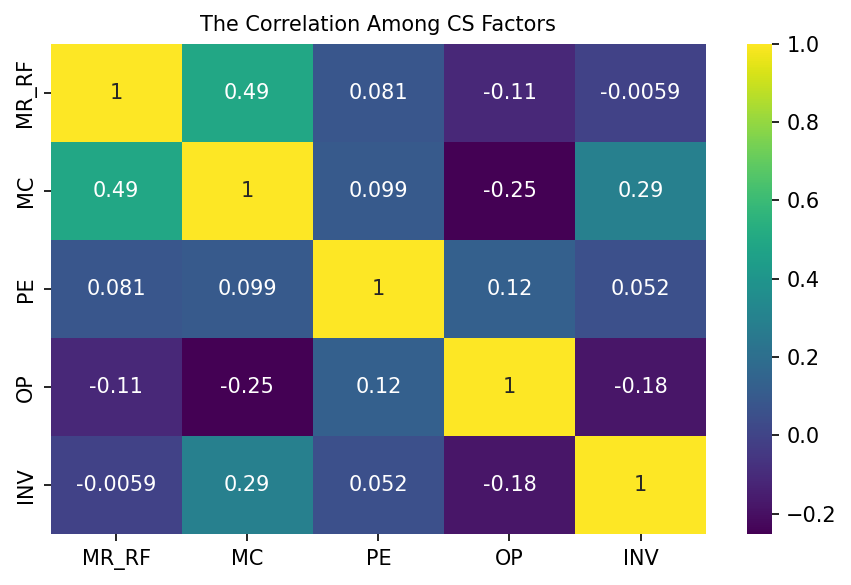

In [843]:
# Plot the correlation among CS factors
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
corrMatrix = df_CS_FF5.corr()
sn.heatmap(corrMatrix, annot=True, cmap="viridis")
plt.title('The Correlation Among CS Factors', fontsize=10)
plt.show()

In [844]:
# FF5CS-Factor Time Series Regression with Newey-West Adjustment
df_Ex_SR_trnct = df_Ex_SR_tmp.loc[df_CS_FF5.index,:]

all_betas = []
all_std_errs = []
all_Rs_CS = []
all_sd_res_CS = []

betas = []
labels = []
std_errs = []
Rs = []
sd_res = []

for j in tqdm(df_Ex_SR.columns):

    df_index = (df_Ex_SR_trnct.loc[:, j].dropna(
    ).index).intersection(df_CS_FF5.index)

    if len(df_index) > 10:
        lag = int(4*((len(df_Ex_SR_trnct.loc[df_index, j]))/100)**(1/9))
        ols = sm.OLS(df_Ex_SR_trnct.loc[df_index, j].astype(np.float64), sm.add_constant(
            df_CS_FF5.loc[df_index, :].astype(np.float64)))
        res = ols.fit()
        res = ols.fit(cov_type='HAC', cov_kwds={'maxlags': lag})
        b = list(res.params)
        se = list(res.bse)
        r = res.rsquared
        sr = res.resid.std()
        betas.append(b)
        std_errs.append(se)
        Rs.append(r)
        sd_res.append(sr)
        labels.append(j)

all_betas.append(pd.DataFrame(betas))
all_std_errs.append(pd.DataFrame(std_errs))
all_Rs_CS.append(pd.DataFrame(Rs))
all_sd_res_CS.append(pd.DataFrame(sd_res))

100%|██████████| 245/245 [00:01<00:00, 133.07it/s]


In [845]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AFT.SJ.Equity   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     9.039
Date:                Thu, 26 May 2022   Prob (F-statistic):           1.52e-08
Time:                        14:30:47   Log-Likelihood:                 7261.3
No. Observations:                3215   AIC:                        -1.451e+04
Df Residuals:                    3209   BIC:                        -1.447e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.753      0.451      -0.000       0.001
MR_RF          0.3236      0.054      5.977      0.000       0.218       0.430
MC            -0.6176      0.200     -3.085      0.002      -1.010      -0.225
PE            -0.7213      0.258     -2.798      0.005      -1.227      -0.216
OP             0.3856      0.221      1.745      0.081      -0.047       0.819
INV            0.2366      0.297      0.798      0.425      -0.345       0.818
==============================================================================
Omnibus:                     2347.896   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           390899.713
Skew:                           2.546   Prob(JB):                         0.00
Kurtosis:                      56.779   Cond. No.                         578.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

In [846]:
df_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
df_betas.columns = ['Intercepts','MKT','Size','PE','OP','INV','Stocks']
df_betas = df_betas.set_index('Stocks')
df_betas

,Intercepts,MKT,Size,PE,OP,INV
Stocks,,,,,,
FDS.SJ.Equity,0.000206,0.204127,3.399913,1.366161,2.597444,3.224395
MOZ.SJ.Equity,0.000719,0.396435,1.124277,0.828141,-0.484250,-1.543846
MTN.SJ.Equity,-0.000310,0.828477,1.178897,-0.401949,0.328430,-0.819010
TRT.SJ.Equity,0.000293,0.275267,-0.460297,-0.573262,0.721198,1.102806
AEG.SJ.Equity,-0.001349,0.625480,0.145674,0.072358,-0.469957,-0.339184
...,...,...,...,...,...,...
MTH.SJ.Equity,-0.001125,1.150754,-0.484420,-0.554346,-0.167428,-0.260827
DIA.SJ.Equity,0.000024,0.314466,-0.565570,-0.428909,-0.642253,1.096690
CTK.SJ.Equity,0.000276,0.371486,-1.066032,-0.919431,1.028851,0.532966


In [847]:
## The alphas are missing pricing errors of asset pricing model (FF5-Factor), which are also the intercepts of time series regression
alphas = df_betas.iloc[:,0]
alphas.describe()

count    243.000000
mean      -0.000095
std        0.001093
min       -0.011356
25%       -0.000273
50%        0.000078
75%        0.000303
max        0.002878
Name: Intercepts, dtype: float64

In [848]:
df_SE = pd.concat([all_std_errs[0], pd.DataFrame(labels)], axis = 1)
df_SE.columns = ['Intercepts','MKT','Size','PE','OP','INV','Stocks']
df_SE = df_SE.set_index('Stocks')
df_SE

,Intercepts,MKT,Size,PE,OP,INV
Stocks,,,,,,
FDS.SJ.Equity,0.005156,0.390501,1.410816,2.211350,2.731644,2.331600
MOZ.SJ.Equity,0.000830,0.138587,0.410822,0.440498,0.412069,0.452100
MTN.SJ.Equity,0.000268,0.038119,0.132268,0.158591,0.102748,0.143425
TRT.SJ.Equity,0.000476,0.055916,0.207599,0.286453,0.244964,0.272327
AEG.SJ.Equity,0.000478,0.068562,0.321564,0.333177,0.362250,0.316920
...,...,...,...,...,...,...
MTH.SJ.Equity,0.002545,0.371680,0.754177,1.554883,0.650012,0.880798
DIA.SJ.Equity,0.000465,0.268509,0.501826,0.442676,0.316725,0.689037
CTK.SJ.Equity,0.000522,0.102051,0.296194,0.375318,0.341845,0.459695


In [849]:
alphas_se = df_SE.iloc[:,0]
alphas_se.describe()

count    243.000000
mean       0.000595
std        0.000595
min        0.000154
25%        0.000269
50%        0.000397
75%        0.000692
max        0.005156
Name: Intercepts, dtype: float64

In [850]:
## Alpha Test (Fama & French, 2020)
### Step 1: Calculate t-statistics of alphas by using the formula: t-stats,i = alphas,i/s.e.(alphas,i)
alphas_t = alphas/alphas_se
alphas_t = alphas_t.replace(-np.inf,np.nan)
alphas_t.describe()

count    243.000000
mean       0.086416
std        1.073896
min       -3.088026
25%       -0.606775
50%        0.197538
75%        0.817345
max        2.940866
Name: Intercepts, dtype: float64

In [851]:
pd.DataFrame(alphas_t)

,Intercepts
Stocks,
FDS.SJ.Equity,0.040000
MOZ.SJ.Equity,0.866252
MTN.SJ.Equity,-1.156108
TRT.SJ.Equity,0.615744
AEG.SJ.Equity,-2.821259
...,...
MTH.SJ.Equity,-0.442174
DIA.SJ.Equity,0.051776
CTK.SJ.Equity,0.528908


#### Results_3

In [852]:
### Calculate the absolute value of alphas and alphas_t, then calculate their mean respectively
print(np.mean(abs(alphas))*21*100,np.nanmean(abs(alphas_t)))

1.1255936384243976 0.8622143435767801


In [853]:
### Calculate the cross-sectional variance of LHS average returns and then divided by the mean of squared alphas
cs_var = np.var(df_SR_tmp.apply(lambda x: np.mean(x), axis = 0))
print(np.mean(np.square(alphas))/cs_var)

1.4878559452345137


In [854]:
### Substract the squared standard error of each intercept to adjust for the noise in the Step-3
A_lamda = np.mean((pd.DataFrame(np.square(alphas).values)-pd.DataFrame(np.square(alphas_se).values)), axis = 0)
print(A_lamda/cs_var)

0    0.61104
dtype: float64


In [855]:
### The average of the regression R^2; the average of the standard errors of the intercepts; 
### The average of the standard deviations of the regression residuals.
print('AR^2: ' + str(np.mean(all_Rs_CS)), 'As(a): ' + str(np.nanmean(alphas_se.values)*np.sqrt(21)), \
      'As(e): ' + str(np.mean(all_sd_res_CS)*np.sqrt(21)))

AR^2: 0.07195355626249389 As(a): 0.0027275106613179672 As(e): 0.1415437360109672


In [856]:
## Calculate Cross-sectional R-squared, how much the total variance of expected stock returns can be explained by the model?
1-(np.var(alphas)/np.var(df_Ex_SR_tmp.mean()))

-0.4580099005265219